## Lista 1 - Disciplina IA006 - Exercícios de Fixação 1

In [19]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [20]:
plt.rcParams['figure.figsize'] = (12.0, 8.0)

In [21]:
class MyData():
    """MyData facilitates manipulation of time series data
    
    This class loads a time series and build features from delayed
    versions of the input data. Also, there is a method for automatically
    spliting data into k-folds.
    """
    
    def __init__(self, array):
        self.years = array[:, 0].copy()
        self.sunspot = array[:, 1:].copy()
        
        # create 20 features which are delays of the original data
        # and remove rows that contains zeros as input features
        flat_sunspot = self.sunspot.flatten()
        data = np.zeros( (flat_sunspot.shape[0], 21) )
        data[:,-1] = flat_sunspot
        for i in range(20):
            data[(i+1):, i] = flat_sunspot[:-(i+1)]
        self.data = data[20:] #drop first 20 lines because of zero'd features
        
        self.features = self.data[:, :-1]
        self.label = self.data[:, -1]
        self.nfeatures = self.features.shape[1]
        self.nrows = self.features.shape[0]
        
    def split_kfold(self, bins, nktest):
        assert (nktest < bins), "Fold selected for test must be within number of K-folds"
        
        nrows = self.nrows
        nelements = np.ceil(nrows/bins)
        
        # mask is True for Test rows and False for Train rows
        mask = np.array([ True if ((i >= nelements*nktest) and (i < nelements*(nktest+1))) 
                          else False 
                          for i in range(nrows)],
                        dtype='bool')

        features_train = self.features[~mask]
        label_train = self.label[~mask]
        features_test = self.features[mask]
        label_test = self.label[mask]
        
        return features_train, label_train, features_test, label_test         

In [22]:
class LinearRegressor():
    """LinearRegressor instances hold a Ridge Linear Regressor
    
    Class of a ridge linear regression model, with methods for fitting
    the model, transforming new data and assessment of model performance.
    """
    
    def __init__(self):
        self.w = None
        self.nfeatures = None
        
    def fit(self, features, label, lamb=0):
        assert (lamb >= 0), "Regularization should be non-negative number."
        
        self.nfeatures = features.shape[1]
        nlines = features.shape[0]
        # first column will be the constant bias
        fea = np.hstack( ( np.ones((nlines,1)), features ) )       
        
        if lamb == 0:
            self.w = np.linalg.inv( fea.T @ fea ) @ fea.T @ label
        if lamb  > 0:
            pseudo_eye = np.eye(fea.shape[1])
            pseudo_eye[0, 0] = 0
            self.w = np.linalg.inv( (fea.T @ fea) + (pseudo_eye * lamb) ) @ fea.T @ label
        return self
    
    def transform(self, x):
        assert (self.w is not None), "Transformer was not trained yet."
        assert (x.shape[1] == self.nfeatures), "Input error: wrong number of columns"
            
        fea = np.zeros( (x.shape[0], x.shape[1] + 1) )
        fea[:, 0] = 1
        fea[:, 1:] = x
        return fea @ self.w
    
    def eval_mse(self, features, label):
        label_pred = self.transform(features)
        return self.mse(label, label_pred)
        
    def mse(self, y_real, y_pred):
        return np.mean(np.square(y_real - y_pred))

In [23]:
class BoolMask():
    """BoolMask is a class for manipulation of boolean masks
    
    This class helps manipulation of boolean masks, aiming at
    numpy array advanced indexing.
    """
    
    def __init__(self, nfeatures=20, mask=None):
        if (mask is not None):
            self.mask = mask.copy()
        else:
            self.mask = np.ones(nfeatures, dtype='bool')
        
    def clearFea(self, feature):
        self.mask[feature] = False
    
    def setFea(self, feature):
        self.mask[feature] = True
        
    def getFea(self, feature):
        return self.mask[feature]
        
    def copy(self):
        r = BoolMask(mask=self.mask)
        return r

In [24]:
## Auxiliar functions
def plot_dual(y_real, y_prediction, title=None, lab1=None, lab2=None):
    if lab1 is None:
        lab1 = 'Série real'
    if lab2 is None:
        lab2 = 'Série estimada'
    
    plt.plot(y_real, label=lab1)
    plt.plot(y_prediction, label=lab2)

    plt.legend()
    plt.xlabel('Meses')
    plt.ylabel('Sunspot')
    if (title != None):
        plt.title(title)
    
    plt.show()
    return

def p_correlation(x, y):
    xm = x - x.mean()
    ym = y - y.mean()
    
    return (xm.dot(ym))/np.sqrt(xm.dot(xm)*ym.dot(ym))

## Preparação para os exercícios
Nessa etapa, os dados de entrada foram carregados a partir do arquivo de entradas `sunspot.txt`. Este arquivo contém a série histórica de medidas do número de manchas solares. Temos a disposição leituras mensais desde 1749 até 2014, o que equivalem a 3192 observações

A classe `MyData` foi utilizada para manipular os dados de entrada. Ela é responsável por transformar a série temporal em dois conjuntos de dados: um vetor de valores esperados para o `i-ésimo` instante e uma matriz de features, onde cada linha corresponde aos features do *i-ésimo* instante, e cada feature é composta por observações passadas (coluna `0` é o instante `i-1`, coluna `1` é o instante `i-2`, etc).

In [25]:
fname = '../data/sunspot.txt'
data = np.loadtxt(fname)
dt = MyData(data)

print("Número de observações do nosso conjunto de dados: ", dt.nrows)
print("Número de features: ", dt.nfeatures)

Número de observações do nosso conjunto de dados:  3172
Número de features:  20


Interessante notar que o número de observações é menor que o esperado. As primeiras 20 observações foram eliminadas pois a ausência de observações passadas poderiam intefirir na regressão linear.

### Exercício 1.a)

Um regressor linear foi construído utilizando *quadrados mínimos irrestrito* como função custo do modelo. O conjunto foi dividido em treino e teste, de forma que os ultimos 5 anos de observações (equivalente à 60 meses) foram teste, e o restante, treino. Este modelo não utiiza regularização.

Erro quadrático médio para dados de treinamento:  15.370232088543426
Erro quadrático médio para dados de teste:  14.24945111274465


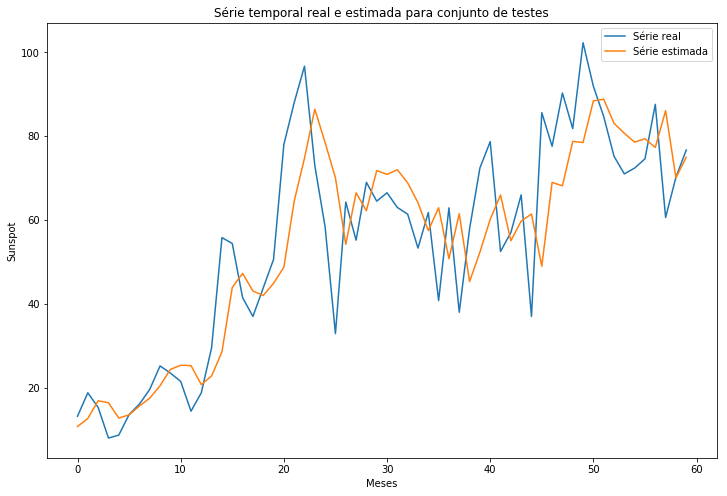

In [26]:
model = LinearRegressor()
testLen = 60

test_features  = dt.features[-testLen:]
train_features = dt.features[:-testLen]
test_label     = dt.label[-testLen:]
train_label    = dt.label[:-testLen]

model.fit(train_features, train_label, lamb=0)
train_pred = model.transform(train_features)
test_pred = model.transform(test_features)

print("Erro quadrático médio para dados de treinamento: ", np.sqrt(model.mse(train_label, train_pred)))
print("Erro quadrático médio para dados de teste: ", np.sqrt(model.mse(test_label, test_pred)))

plot_dual(test_label, test_pred, "Série temporal real e estimada para conjunto de testes")

Os erros (erro quadrático médio) de treinamento e teste foram, respectivamente, `15.37` e `14.25`. Em geral, utilizando-se a técnica de *Holdout* o erro do conjunto de testes tende a ser maior que o erro do arquivo de treino. Entretanto, situações onde o conjunto de teste não contempla toda a variabilidade do conjunto de treino (por exemplo, um desbalanceamento de classes em um problema de classificação), a situação pode se inverter. Isso é um indicativo de que técnicas como *K-Fold Validation* poderiam beneficiar a análise.

A figura acima apresenta a série temporal real e a estimativa do modelo linear para o conjunto de dados de teste. É interessante notar que a série estimada acompanha a série real, o que sugere que nosso modelo linear está correto, porém com um atraso de 1 mês. Esta característica sugere que o poder de predição do nosso modelo se limita a prever o próximo valor da série como o valor do mês anterior.

Essa característica fica clara ao adiantar-se de forma sintética a série estima:

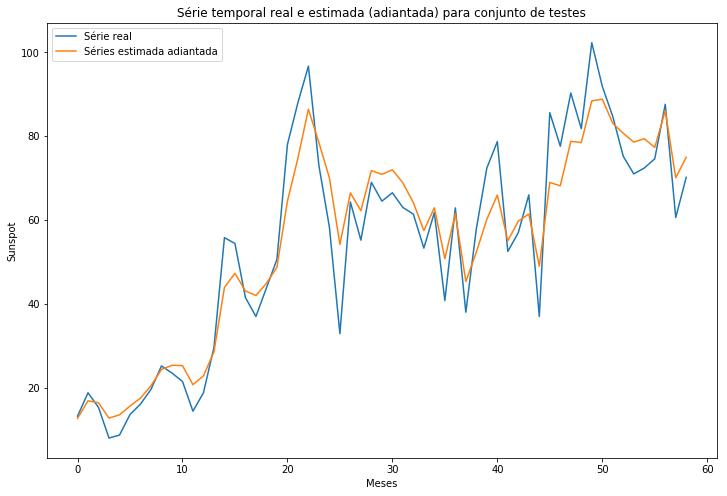

In [27]:
plot_dual(test_label[:-1], test_pred[1:], "Série temporal real e estimada (adiantada) para conjunto de testes",
          "Série real", "Séries estimada adiantada")

Esse comportamento não se trata de um erro na execução da regressão linear, e sim de uma dificuldade inerente à series temporais, pois a unica informação que o modelo construído tem acesso é de instantes de tempos passados da série de interesse.

### Exercício 1.b)
Agora, vamos considerar a aplicação da estratégia de seleção de variáveis
denominada wrapper, seguindo a abordagem backward elimination. Ademais,
a fim de medirmos de forma mais robusta o desempenho de cada subconjunto
de variáveis de entrada, vamos utilizar um esquema de validação cruzada do
tipo -fold. Por fim, vamos também considerar a técnica ridge regression
para a regularização do modelo.

Nesta etapa, empregou-se a técnica de wrapper, seguindo a abordagem backward elimination, para redução de features. Além disso, a medida de desempenho foi feita utilizando-se o esquema de validação cruzada K-fold, que é um método mais robusto que Holdout. Por fim, a regressão linear foi modificada para aceitar um parâmetro *lambda* de regularização. Para cada conjunto de features, testaram-se diferentes valores de lambda dentro do range de `1,5^-1` até `1,5^30`.

In [28]:
def kfold_loop(featureMask, data, nFolds):
    mse = 0
    for k in range(nFolds):
        # k-fold loop
        features_train, label_train, features_test, label_test = data.split_kfold(nFolds, k)
        model = LinearRegressor()
        model.fit(features_train[:, featureMask], label_train, lamb=lamb)
        mse += model.eval_mse(features_test[:, featureMask], label_test)
    mse /= nFolds
    return np.sqrt(mse)

# Defining boolMask for features
kfNum = 10 # Number of folds
ridgeList = np.array([1.5**k for k in range(-1, 30)]) # List of lambdas to be tested
mask = BoolMask(20) # Boolean mask for removing features (columns)
wrapperResult = {} # Dict to store results
for wrap in range(dt.nfeatures - 1, 0, -1): 
    bestRmse = np.inf
    bestLamb = None
    bestMask = None
    for fea in range(dt.nfeatures):
        if mask.getFea(fea):
            mask.clearFea(fea)
            print("Mask: ", mask.mask)
            for lamb in ridgeList:
                currRmse = kfold_loop(mask.mask, dt, kfNum) 
                print('kfold rmse: {}, Wrapper #: {}, Feat. removida: {}, lambda: {:<7.10f}'
                        .format(currRmse, wrap, fea, lamb))
                if currRmse < bestRmse:
                    print('currRmse: {}, bestRmse: {}'.format(currRmse, bestRmse))
                    bestRmse = currRmse
                    bestLamb = lamb
                    bestMask = mask.copy()
            mask.setFea(fea)
    wrapperResult['Utilizando_{}_features'.format(wrap)] = {'RMSE': bestRmse, 'Lambda': bestLamb, 'Features': bestMask.mask}
    mask = bestMask

Mask:  [False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
kfold rmse: 17.654729219151843, Wrapper #: 19, Feat. removida: 0, lambda: 0.6666666667
currRmse: 17.654729219151843, bestRmse: inf
kfold rmse: 17.654729148172517, Wrapper #: 19, Feat. removida: 0, lambda: 1.0000000000
currRmse: 17.654729148172517, bestRmse: 17.654729219151843
kfold rmse: 17.654729041704286, Wrapper #: 19, Feat. removida: 0, lambda: 1.5000000000
currRmse: 17.654729041704286, bestRmse: 17.654729148172517
kfold rmse: 17.65472888200382, Wrapper #: 19, Feat. removida: 0, lambda: 2.2500000000
currRmse: 17.65472888200382, bestRmse: 17.654729041704286
kfold rmse: 17.654728642457385, Wrapper #: 19, Feat. removida: 0, lambda: 3.3750000000
currRmse: 17.654728642457385, bestRmse: 17.65472888200382
kfold rmse: 17.654728283147154, Wrapper #: 19, Feat. removida: 0, lambda: 5.0625000000
currRmse: 17.654728283147154, bestRmse: 17.654728642457385
kfold rmse: 

kfold rmse: 15.541728189502004, Wrapper #: 19, Feat. removida: 1, lambda: 25251.1682940423
currRmse: 15.541728189502004, bestRmse: 15.541980433155285
kfold rmse: 15.542300356526624, Wrapper #: 19, Feat. removida: 1, lambda: 37876.7524410635
kfold rmse: 15.545057438166637, Wrapper #: 19, Feat. removida: 1, lambda: 56815.1286615953
kfold rmse: 15.552787283039542, Wrapper #: 19, Feat. removida: 1, lambda: 85222.6929923929
kfold rmse: 15.570684329421631, Wrapper #: 19, Feat. removida: 1, lambda: 127834.0394885894
Mask:  [ True  True False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
kfold rmse: 15.541808674772943, Wrapper #: 19, Feat. removida: 2, lambda: 0.6666666667
kfold rmse: 15.541808607774861, Wrapper #: 19, Feat. removida: 2, lambda: 1.0000000000
kfold rmse: 15.541808507279592, Wrapper #: 19, Feat. removida: 2, lambda: 1.5000000000
kfold rmse: 15.541808356541127, Wrapper #: 19, Feat. removida: 2, lambda: 2.2500000000
kfold r

kfold rmse: 15.494507193152954, Wrapper #: 19, Feat. removida: 4, lambda: 1.5000000000
currRmse: 15.494507193152954, bestRmse: 15.49450730115908
kfold rmse: 15.494507031148242, Wrapper #: 19, Feat. removida: 4, lambda: 2.2500000000
currRmse: 15.494507031148242, bestRmse: 15.494507193152954
kfold rmse: 15.494506788151435, Wrapper #: 19, Feat. removida: 4, lambda: 3.3750000000
currRmse: 15.494506788151435, bestRmse: 15.494507031148242
kfold rmse: 15.494506423678994, Wrapper #: 19, Feat. removida: 4, lambda: 5.0625000000
currRmse: 15.494506423678994, bestRmse: 15.494506788151435
kfold rmse: 15.49450587702192, Wrapper #: 19, Feat. removida: 4, lambda: 7.5937500000
currRmse: 15.49450587702192, bestRmse: 15.494506423678994
kfold rmse: 15.494505057152164, Wrapper #: 19, Feat. removida: 4, lambda: 11.3906250000
currRmse: 15.494505057152164, bestRmse: 15.49450587702192
kfold rmse: 15.494503827608312, Wrapper #: 19, Feat. removida: 4, lambda: 17.0859375000
currRmse: 15.494503827608312, bestRmse:

kfold rmse: 15.489227241975872, Wrapper #: 19, Feat. removida: 6, lambda: 17.0859375000
currRmse: 15.489227241975872, bestRmse: 15.489228427566525
kfold rmse: 15.489225464175695, Wrapper #: 19, Feat. removida: 6, lambda: 25.6289062500
currRmse: 15.489225464175695, bestRmse: 15.489227241975872
kfold rmse: 15.489222798793394, Wrapper #: 19, Feat. removida: 6, lambda: 38.4433593750
currRmse: 15.489222798793394, bestRmse: 15.489225464175695
kfold rmse: 15.489218803684818, Wrapper #: 19, Feat. removida: 6, lambda: 57.6650390625
currRmse: 15.489218803684818, bestRmse: 15.489222798793394
kfold rmse: 15.489212817691188, Wrapper #: 19, Feat. removida: 6, lambda: 86.4975585938
currRmse: 15.489212817691188, bestRmse: 15.489218803684818
kfold rmse: 15.489203853700829, Wrapper #: 19, Feat. removida: 6, lambda: 129.7463378906
currRmse: 15.489203853700829, bestRmse: 15.489212817691188
kfold rmse: 15.489190441446306, Wrapper #: 19, Feat. removida: 6, lambda: 194.6195068359
currRmse: 15.489190441446306

kfold rmse: 15.539465319385469, Wrapper #: 19, Feat. removida: 8, lambda: 11222.7414640188
kfold rmse: 15.538971160554468, Wrapper #: 19, Feat. removida: 8, lambda: 16834.1121960282
kfold rmse: 15.538684708260078, Wrapper #: 19, Feat. removida: 8, lambda: 25251.1682940423
kfold rmse: 15.539178792098038, Wrapper #: 19, Feat. removida: 8, lambda: 37876.7524410635
kfold rmse: 15.541709721472783, Wrapper #: 19, Feat. removida: 8, lambda: 56815.1286615953
kfold rmse: 15.548748882193754, Wrapper #: 19, Feat. removida: 8, lambda: 85222.6929923929
kfold rmse: 15.564653915207192, Wrapper #: 19, Feat. removida: 8, lambda: 127834.0394885894
Mask:  [ True  True  True  True  True  True  True  True  True False  True  True
  True  True  True  True  True  True  True  True]
kfold rmse: 15.489239144576185, Wrapper #: 19, Feat. removida: 9, lambda: 0.6666666667
kfold rmse: 15.489239076287252, Wrapper #: 19, Feat. removida: 9, lambda: 1.0000000000
kfold rmse: 15.489238973855862, Wrapper #: 19, Feat. remov

kfold rmse: 15.48589783305598, Wrapper #: 19, Feat. removida: 11, lambda: 2216.8378200531
currRmse: 15.48589783305598, bestRmse: 15.486027663946203
kfold rmse: 15.485712743289557, Wrapper #: 19, Feat. removida: 11, lambda: 3325.2567300797
currRmse: 15.485712743289557, bestRmse: 15.48589783305598
kfold rmse: 15.485456523096282, Wrapper #: 19, Feat. removida: 11, lambda: 4987.8850951195
currRmse: 15.485456523096282, bestRmse: 15.485712743289557
kfold rmse: 15.485119342822609, Wrapper #: 19, Feat. removida: 11, lambda: 7481.8276426792
currRmse: 15.485119342822609, bestRmse: 15.485456523096282
kfold rmse: 15.484716288953656, Wrapper #: 19, Feat. removida: 11, lambda: 11222.7414640188
currRmse: 15.484716288953656, bestRmse: 15.485119342822609
kfold rmse: 15.484331989743346, Wrapper #: 19, Feat. removida: 11, lambda: 16834.1121960282
currRmse: 15.484331989743346, bestRmse: 15.484716288953656
kfold rmse: 15.484217182715103, Wrapper #: 19, Feat. removida: 11, lambda: 25251.1682940423
currRmse:

kfold rmse: 15.484948656941272, Wrapper #: 19, Feat. removida: 14, lambda: 57.6650390625
kfold rmse: 15.484943098381269, Wrapper #: 19, Feat. removida: 14, lambda: 86.4975585938
kfold rmse: 15.484934775659825, Wrapper #: 19, Feat. removida: 14, lambda: 129.7463378906
kfold rmse: 15.484922325575072, Wrapper #: 19, Feat. removida: 14, lambda: 194.6195068359
kfold rmse: 15.48490372687687, Wrapper #: 19, Feat. removida: 14, lambda: 291.9292602539
kfold rmse: 15.48487600057489, Wrapper #: 19, Feat. removida: 14, lambda: 437.8938903809
kfold rmse: 15.484834796808693, Wrapper #: 19, Feat. removida: 14, lambda: 656.8408355713
kfold rmse: 15.484773856463528, Wrapper #: 19, Feat. removida: 14, lambda: 985.2612533569
kfold rmse: 15.484684384510153, Wrapper #: 19, Feat. removida: 14, lambda: 1477.8918800354
kfold rmse: 15.484554510288055, Wrapper #: 19, Feat. removida: 14, lambda: 2216.8378200531
kfold rmse: 15.48436935602561, Wrapper #: 19, Feat. removida: 14, lambda: 3325.2567300797
kfold rmse: 

kfold rmse: 15.480696531881428, Wrapper #: 19, Feat. removida: 16, lambda: 25251.1682940423
currRmse: 15.480696531881428, bestRmse: 15.480714647910068
kfold rmse: 15.481578287473498, Wrapper #: 19, Feat. removida: 16, lambda: 37876.7524410635
kfold rmse: 15.484664258902031, Wrapper #: 19, Feat. removida: 16, lambda: 56815.1286615953
kfold rmse: 15.492492914544043, Wrapper #: 19, Feat. removida: 16, lambda: 85222.6929923929
kfold rmse: 15.50951874510191, Wrapper #: 19, Feat. removida: 16, lambda: 127834.0394885894
Mask:  [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False  True  True]
kfold rmse: 15.517968188855871, Wrapper #: 19, Feat. removida: 17, lambda: 0.6666666667
kfold rmse: 15.517968122451274, Wrapper #: 19, Feat. removida: 17, lambda: 1.0000000000
kfold rmse: 15.517968022846347, Wrapper #: 19, Feat. removida: 17, lambda: 1.5000000000
kfold rmse: 15.517967873443228, Wrapper #: 19, Feat. removida: 17, lambda: 2.2500000000

kfold rmse: 15.510874052424507, Wrapper #: 19, Feat. removida: 19, lambda: 11222.7414640188
kfold rmse: 15.510326012146486, Wrapper #: 19, Feat. removida: 19, lambda: 16834.1121960282
kfold rmse: 15.509969641822838, Wrapper #: 19, Feat. removida: 19, lambda: 25251.1682940423
kfold rmse: 15.510381256534405, Wrapper #: 19, Feat. removida: 19, lambda: 37876.7524410635
kfold rmse: 15.51283279319025, Wrapper #: 19, Feat. removida: 19, lambda: 56815.1286615953
kfold rmse: 15.519836235035193, Wrapper #: 19, Feat. removida: 19, lambda: 85222.6929923929
kfold rmse: 15.535835620354602, Wrapper #: 19, Feat. removida: 19, lambda: 127834.0394885894
Mask:  [False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False  True  True  True]
kfold rmse: 17.653762725277712, Wrapper #: 18, Feat. removida: 0, lambda: 0.6666666667
currRmse: 17.653762725277712, bestRmse: inf
kfold rmse: 17.653762659899098, Wrapper #: 18, Feat. removida: 0, lambda: 1.0000000000
currRmse

kfold rmse: 15.532573602089093, Wrapper #: 18, Feat. removida: 1, lambda: 37876.7524410635
kfold rmse: 15.535859881518087, Wrapper #: 18, Feat. removida: 1, lambda: 56815.1286615953
kfold rmse: 15.544229853442426, Wrapper #: 18, Feat. removida: 1, lambda: 85222.6929923929
kfold rmse: 15.562857049628073, Wrapper #: 18, Feat. removida: 1, lambda: 127834.0394885894
Mask:  [ True  True False  True  True  True  True  True  True  True  True  True
  True  True  True  True False  True  True  True]
kfold rmse: 15.529215772244122, Wrapper #: 18, Feat. removida: 2, lambda: 0.6666666667
currRmse: 15.529215772244122, bestRmse: 15.531531595569437
kfold rmse: 15.529215720590694, Wrapper #: 18, Feat. removida: 2, lambda: 1.0000000000
currRmse: 15.529215720590694, bestRmse: 15.529215772244122
kfold rmse: 15.529215643112385, Wrapper #: 18, Feat. removida: 2, lambda: 1.5000000000
currRmse: 15.529215643112385, bestRmse: 15.529215720590694
kfold rmse: 15.529215526898968, Wrapper #: 18, Feat. removida: 2, l

kfold rmse: 15.518700198287487, Wrapper #: 18, Feat. removida: 3, lambda: 25251.1682940423
kfold rmse: 15.51967872646233, Wrapper #: 18, Feat. removida: 3, lambda: 37876.7524410635
kfold rmse: 15.522848263403967, Wrapper #: 18, Feat. removida: 3, lambda: 56815.1286615953
kfold rmse: 15.530692354446563, Wrapper #: 18, Feat. removida: 3, lambda: 85222.6929923929
kfold rmse: 15.547570709016636, Wrapper #: 18, Feat. removida: 3, lambda: 127834.0394885894
Mask:  [ True  True  True  True False  True  True  True  True  True  True  True
  True  True  True  True False  True  True  True]
kfold rmse: 15.48291298347573, Wrapper #: 18, Feat. removida: 4, lambda: 0.6666666667
currRmse: 15.48291298347573, bestRmse: 15.518632580139943
kfold rmse: 15.482912927280251, Wrapper #: 18, Feat. removida: 4, lambda: 1.0000000000
currRmse: 15.482912927280251, bestRmse: 15.48291298347573
kfold rmse: 15.482912842988979, Wrapper #: 18, Feat. removida: 4, lambda: 1.5000000000
currRmse: 15.482912842988979, bestRmse:

kfold rmse: 15.477829766160726, Wrapper #: 18, Feat. removida: 6, lambda: 86.4975585938
currRmse: 15.477829766160726, bestRmse: 15.47783444327306
kfold rmse: 15.47782276460825, Wrapper #: 18, Feat. removida: 6, lambda: 129.7463378906
currRmse: 15.47782276460825, bestRmse: 15.477829766160726
kfold rmse: 15.477812294023012, Wrapper #: 18, Feat. removida: 6, lambda: 194.6195068359
currRmse: 15.477812294023012, bestRmse: 15.47782276460825
kfold rmse: 15.47779665950892, Wrapper #: 18, Feat. removida: 6, lambda: 291.9292602539
currRmse: 15.47779665950892, bestRmse: 15.477812294023012
kfold rmse: 15.477773368107238, Wrapper #: 18, Feat. removida: 6, lambda: 437.8938903809
currRmse: 15.477773368107238, bestRmse: 15.47779665950892
kfold rmse: 15.477738791165669, Wrapper #: 18, Feat. removida: 6, lambda: 656.8408355713
currRmse: 15.477738791165669, bestRmse: 15.477773368107238
kfold rmse: 15.477687733859318, Wrapper #: 18, Feat. removida: 6, lambda: 985.2612533569
currRmse: 15.477687733859318, b

kfold rmse: 15.556240990516432, Wrapper #: 18, Feat. removida: 8, lambda: 127834.0394885894
Mask:  [ True  True  True  True  True  True  True  True  True False  True  True
  True  True  True  True False  True  True  True]
kfold rmse: 15.47766302760375, Wrapper #: 18, Feat. removida: 9, lambda: 0.6666666667
kfold rmse: 15.477662974445595, Wrapper #: 18, Feat. removida: 9, lambda: 1.0000000000
kfold rmse: 15.47766289471027, Wrapper #: 18, Feat. removida: 9, lambda: 1.5000000000
kfold rmse: 15.477662775111503, Wrapper #: 18, Feat. removida: 9, lambda: 2.2500000000
kfold rmse: 15.47766259572292, Wrapper #: 18, Feat. removida: 9, lambda: 3.3750000000
kfold rmse: 15.477662326661592, Wrapper #: 18, Feat. removida: 9, lambda: 5.0625000000
kfold rmse: 15.477661923118049, Wrapper #: 18, Feat. removida: 9, lambda: 7.5937500000
kfold rmse: 15.477661317911604, Wrapper #: 18, Feat. removida: 9, lambda: 11.3906250000
kfold rmse: 15.477660410347099, Wrapper #: 18, Feat. removida: 9, lambda: 17.0859375

kfold rmse: 15.474701376920883, Wrapper #: 18, Feat. removida: 11, lambda: 656.8408355713
currRmse: 15.474701376920883, bestRmse: 15.474732404826643
kfold rmse: 15.474655648591446, Wrapper #: 18, Feat. removida: 11, lambda: 985.2612533569
currRmse: 15.474655648591446, bestRmse: 15.474701376920883
kfold rmse: 15.474588878876135, Wrapper #: 18, Feat. removida: 11, lambda: 1477.8918800354
currRmse: 15.474588878876135, bestRmse: 15.474655648591446
kfold rmse: 15.474492799862846, Wrapper #: 18, Feat. removida: 11, lambda: 2216.8378200531
currRmse: 15.474492799862846, bestRmse: 15.474588878876135
kfold rmse: 15.474357765470785, Wrapper #: 18, Feat. removida: 11, lambda: 3325.2567300797
currRmse: 15.474357765470785, bestRmse: 15.474492799862846
kfold rmse: 15.47417536746503, Wrapper #: 18, Feat. removida: 11, lambda: 4987.8850951195
currRmse: 15.47417536746503, bestRmse: 15.474357765470785
kfold rmse: 15.47394617226919, Wrapper #: 18, Feat. removida: 11, lambda: 7481.8276426792
currRmse: 15.4

kfold rmse: 15.473766919504806, Wrapper #: 18, Feat. removida: 14, lambda: 194.6195068359
kfold rmse: 15.473752878653297, Wrapper #: 18, Feat. removida: 14, lambda: 291.9292602539
kfold rmse: 15.4737319789365, Wrapper #: 18, Feat. removida: 14, lambda: 437.8938903809
kfold rmse: 15.473700992194747, Wrapper #: 18, Feat. removida: 14, lambda: 656.8408355713
kfold rmse: 15.473655326177171, Wrapper #: 18, Feat. removida: 14, lambda: 985.2612533569
kfold rmse: 15.473588651201506, Wrapper #: 18, Feat. removida: 14, lambda: 1477.8918800354
kfold rmse: 15.473492717154345, Wrapper #: 18, Feat. removida: 14, lambda: 2216.8378200531
currRmse: 15.473492717154345, bestRmse: 15.473536653803997
kfold rmse: 15.473357906618148, Wrapper #: 18, Feat. removida: 14, lambda: 3325.2567300797
currRmse: 15.473357906618148, bestRmse: 15.473492717154345
kfold rmse: 15.473175858724428, Wrapper #: 18, Feat. removida: 14, lambda: 4987.8850951195
currRmse: 15.473175858724428, bestRmse: 15.473357906618148
kfold rmse:

kfold rmse: 15.480814088694915, Wrapper #: 18, Feat. removida: 18, lambda: 38.4433593750
kfold rmse: 15.480810886883786, Wrapper #: 18, Feat. removida: 18, lambda: 57.6650390625
kfold rmse: 15.480806090402943, Wrapper #: 18, Feat. removida: 18, lambda: 86.4975585938
kfold rmse: 15.480798909707389, Wrapper #: 18, Feat. removida: 18, lambda: 129.7463378906
kfold rmse: 15.480788170205036, Wrapper #: 18, Feat. removida: 18, lambda: 194.6195068359
kfold rmse: 15.480772131861793, Wrapper #: 18, Feat. removida: 18, lambda: 291.9292602539
kfold rmse: 15.480748233703315, Wrapper #: 18, Feat. removida: 18, lambda: 437.8938903809
kfold rmse: 15.480712744371337, Wrapper #: 18, Feat. removida: 18, lambda: 656.8408355713
kfold rmse: 15.480660313486934, Wrapper #: 18, Feat. removida: 18, lambda: 985.2612533569
kfold rmse: 15.480583466857311, Wrapper #: 18, Feat. removida: 18, lambda: 1477.8918800354
kfold rmse: 15.480472221717724, Wrapper #: 18, Feat. removida: 18, lambda: 2216.8378200531
kfold rmse:

kfold rmse: 17.644809469560794, Wrapper #: 17, Feat. removida: 0, lambda: 56815.1286615953
currRmse: 17.644809469560794, bestRmse: 17.645589006678577
kfold rmse: 17.64512570757896, Wrapper #: 17, Feat. removida: 0, lambda: 85222.6929923929
kfold rmse: 17.648258852694998, Wrapper #: 17, Feat. removida: 0, lambda: 127834.0394885894
Mask:  [ True False  True  True  True  True  True  True  True  True  True  True
  True  True False  True False  True  True  True]
kfold rmse: 15.523803486918457, Wrapper #: 17, Feat. removida: 1, lambda: 0.6666666667
currRmse: 15.523803486918457, bestRmse: 17.644809469560794
kfold rmse: 15.52380344463951, Wrapper #: 17, Feat. removida: 1, lambda: 1.0000000000
currRmse: 15.52380344463951, bestRmse: 15.523803486918457
kfold rmse: 15.523803381222852, Wrapper #: 17, Feat. removida: 1, lambda: 1.5000000000
currRmse: 15.523803381222852, bestRmse: 15.52380344463951
kfold rmse: 15.523803286101755, Wrapper #: 17, Feat. removida: 1, lambda: 2.2500000000
currRmse: 15.523

kfold rmse: 15.519029419711638, Wrapper #: 17, Feat. removida: 2, lambda: 25251.1682940423
kfold rmse: 15.520317537234503, Wrapper #: 17, Feat. removida: 2, lambda: 37876.7524410635
kfold rmse: 15.523867247261549, Wrapper #: 17, Feat. removida: 2, lambda: 56815.1286615953
kfold rmse: 15.53214462274935, Wrapper #: 17, Feat. removida: 2, lambda: 85222.6929923929
kfold rmse: 15.549493726805082, Wrapper #: 17, Feat. removida: 2, lambda: 127834.0394885894
Mask:  [ True  True  True False  True  True  True  True  True  True  True  True
  True  True False  True False  True  True  True]
kfold rmse: 15.512679606232535, Wrapper #: 17, Feat. removida: 3, lambda: 0.6666666667
currRmse: 15.512679606232535, bestRmse: 15.518724684700135
kfold rmse: 15.51267956122753, Wrapper #: 17, Feat. removida: 3, lambda: 1.0000000000
currRmse: 15.51267956122753, bestRmse: 15.512679606232535
kfold rmse: 15.512679493721857, Wrapper #: 17, Feat. removida: 3, lambda: 1.5000000000
currRmse: 15.512679493721857, bestRmse

kfold rmse: 15.472888916466518, Wrapper #: 17, Feat. removida: 4, lambda: 11222.7414640188
currRmse: 15.472888916466518, bestRmse: 15.473115498361567
kfold rmse: 15.472751439181666, Wrapper #: 17, Feat. removida: 4, lambda: 16834.1121960282
currRmse: 15.472751439181666, bestRmse: 15.472888916466518
kfold rmse: 15.472970551710304, Wrapper #: 17, Feat. removida: 4, lambda: 25251.1682940423
kfold rmse: 15.47416448765975, Wrapper #: 17, Feat. removida: 4, lambda: 37876.7524410635
kfold rmse: 15.477634969913693, Wrapper #: 17, Feat. removida: 4, lambda: 56815.1286615953
kfold rmse: 15.485889536353278, Wrapper #: 17, Feat. removida: 4, lambda: 85222.6929923929
kfold rmse: 15.503304695069522, Wrapper #: 17, Feat. removida: 4, lambda: 127834.0394885894
Mask:  [ True  True  True  True  True False  True  True  True  True  True  True
  True  True False  True False  True  True  True]
kfold rmse: 15.496914549138728, Wrapper #: 17, Feat. removida: 5, lambda: 0.6666666667
kfold rmse: 15.4969145010540

kfold rmse: 15.473685783713899, Wrapper #: 17, Feat. removida: 7, lambda: 1.0000000000
kfold rmse: 15.473685716835648, Wrapper #: 17, Feat. removida: 7, lambda: 1.5000000000
kfold rmse: 15.473685616522445, Wrapper #: 17, Feat. removida: 7, lambda: 2.2500000000
kfold rmse: 15.473685466062129, Wrapper #: 17, Feat. removida: 7, lambda: 3.3750000000
kfold rmse: 15.473685240392955, Wrapper #: 17, Feat. removida: 7, lambda: 5.0625000000
kfold rmse: 15.473684901937164, Wrapper #: 17, Feat. removida: 7, lambda: 7.5937500000
kfold rmse: 15.47368439436134, Wrapper #: 17, Feat. removida: 7, lambda: 11.3906250000
kfold rmse: 15.473683633240363, Wrapper #: 17, Feat. removida: 7, lambda: 17.0859375000
kfold rmse: 15.47368249210507, Wrapper #: 17, Feat. removida: 7, lambda: 25.6289062500
kfold rmse: 15.473680781630684, Wrapper #: 17, Feat. removida: 7, lambda: 38.4433593750
kfold rmse: 15.473678218683082, Wrapper #: 17, Feat. removida: 7, lambda: 57.6650390625
kfold rmse: 15.473674380479139, Wrapper 

kfold rmse: 15.48179136407027, Wrapper #: 17, Feat. removida: 9, lambda: 85222.6929923929
kfold rmse: 15.499790925697988, Wrapper #: 17, Feat. removida: 9, lambda: 127834.0394885894
Mask:  [ True  True  True  True  True  True  True  True  True  True False  True
  True  True False  True False  True  True  True]
kfold rmse: 15.472003260829656, Wrapper #: 17, Feat. removida: 10, lambda: 0.6666666667
kfold rmse: 15.47200322010365, Wrapper #: 17, Feat. removida: 10, lambda: 1.0000000000
kfold rmse: 15.472003159016534, Wrapper #: 17, Feat. removida: 10, lambda: 1.5000000000
kfold rmse: 15.472003067389982, Wrapper #: 17, Feat. removida: 10, lambda: 2.2500000000
kfold rmse: 15.472002929959508, Wrapper #: 17, Feat. removida: 10, lambda: 3.3750000000
kfold rmse: 15.472002723834866, Wrapper #: 17, Feat. removida: 10, lambda: 5.0625000000
kfold rmse: 15.472002414695298, Wrapper #: 17, Feat. removida: 10, lambda: 7.5937500000
kfold rmse: 15.472001951092524, Wrapper #: 17, Feat. removida: 10, lambda

kfold rmse: 15.467918875827564, Wrapper #: 17, Feat. removida: 12, lambda: 7.5937500000
kfold rmse: 15.467918451958415, Wrapper #: 17, Feat. removida: 12, lambda: 11.3906250000
kfold rmse: 15.467917816391832, Wrapper #: 17, Feat. removida: 12, lambda: 17.0859375000
kfold rmse: 15.467916863575459, Wrapper #: 17, Feat. removida: 12, lambda: 25.6289062500
kfold rmse: 15.467915435551188, Wrapper #: 17, Feat. removida: 12, lambda: 38.4433593750
kfold rmse: 15.467913296214896, Wrapper #: 17, Feat. removida: 12, lambda: 57.6650390625
kfold rmse: 15.467910093284337, Wrapper #: 17, Feat. removida: 12, lambda: 86.4975585938
kfold rmse: 15.46790530254966, Wrapper #: 17, Feat. removida: 12, lambda: 129.7463378906
kfold rmse: 15.467898147168238, Wrapper #: 17, Feat. removida: 12, lambda: 194.6195068359
kfold rmse: 15.467887483160261, Wrapper #: 17, Feat. removida: 12, lambda: 291.9292602539
kfold rmse: 15.467871642349944, Wrapper #: 17, Feat. removida: 12, lambda: 437.8938903809
kfold rmse: 15.4678

kfold rmse: 15.500376957461665, Wrapper #: 17, Feat. removida: 17, lambda: 2.2500000000
kfold rmse: 15.500376810701377, Wrapper #: 17, Feat. removida: 17, lambda: 3.3750000000
kfold rmse: 15.500376590581714, Wrapper #: 17, Feat. removida: 17, lambda: 5.0625000000
kfold rmse: 15.500376260449192, Wrapper #: 17, Feat. removida: 17, lambda: 7.5937500000
kfold rmse: 15.50037576535602, Wrapper #: 17, Feat. removida: 17, lambda: 11.3906250000
kfold rmse: 15.500375022953872, Wrapper #: 17, Feat. removida: 17, lambda: 17.0859375000
kfold rmse: 15.500373909885194, Wrapper #: 17, Feat. removida: 17, lambda: 25.6289062500
kfold rmse: 15.500372241484813, Wrapper #: 17, Feat. removida: 17, lambda: 38.4433593750
kfold rmse: 15.500369741589722, Wrapper #: 17, Feat. removida: 17, lambda: 57.6650390625
kfold rmse: 15.500365997832997, Wrapper #: 17, Feat. removida: 17, lambda: 86.4975585938
kfold rmse: 15.500360395886242, Wrapper #: 17, Feat. removida: 17, lambda: 129.7463378906
kfold rmse: 15.5003520237

kfold rmse: 17.64690269319584, Wrapper #: 16, Feat. removida: 0, lambda: 0.6666666667
currRmse: 17.64690269319584, bestRmse: inf
kfold rmse: 17.646902636076092, Wrapper #: 16, Feat. removida: 0, lambda: 1.0000000000
currRmse: 17.646902636076092, bestRmse: 17.64690269319584
kfold rmse: 17.646902550397286, Wrapper #: 16, Feat. removida: 0, lambda: 1.5000000000
currRmse: 17.646902550397286, bestRmse: 17.646902636076092
kfold rmse: 17.646902421880757, Wrapper #: 16, Feat. removida: 0, lambda: 2.2500000000
currRmse: 17.646902421880757, bestRmse: 17.646902550397286
kfold rmse: 17.646902229109834, Wrapper #: 16, Feat. removida: 0, lambda: 3.3750000000
currRmse: 17.646902229109834, bestRmse: 17.646902421880757
kfold rmse: 17.6469019399621, Wrapper #: 16, Feat. removida: 0, lambda: 5.0625000000
currRmse: 17.6469019399621, bestRmse: 17.646902229109834
kfold rmse: 17.646901506260097, Wrapper #: 16, Feat. removida: 0, lambda: 7.5937500000
currRmse: 17.646901506260097, bestRmse: 17.6469019399621
kf

kfold rmse: 15.521541480630484, Wrapper #: 16, Feat. removida: 1, lambda: 56815.1286615953
kfold rmse: 15.531000468981492, Wrapper #: 16, Feat. removida: 1, lambda: 85222.6929923929
kfold rmse: 15.550935714207075, Wrapper #: 16, Feat. removida: 1, lambda: 127834.0394885894
Mask:  [ True  True False  True  True  True  True  True  True  True  True False
  True  True False  True False  True  True  True]
kfold rmse: 15.511996168149048, Wrapper #: 16, Feat. removida: 2, lambda: 0.6666666667
currRmse: 15.511996168149048, bestRmse: 15.51522578078877
kfold rmse: 15.511996137475414, Wrapper #: 16, Feat. removida: 2, lambda: 1.0000000000
currRmse: 15.511996137475414, bestRmse: 15.511996168149048
kfold rmse: 15.51199609146674, Wrapper #: 16, Feat. removida: 2, lambda: 1.5000000000
currRmse: 15.51199609146674, bestRmse: 15.511996137475414
kfold rmse: 15.511996022457595, Wrapper #: 16, Feat. removida: 2, lambda: 2.2500000000
currRmse: 15.511996022457595, bestRmse: 15.51199609146674
kfold rmse: 15.5

kfold rmse: 15.503969809875947, Wrapper #: 16, Feat. removida: 3, lambda: 16834.1121960282
kfold rmse: 15.50443786598454, Wrapper #: 16, Feat. removida: 3, lambda: 25251.1682940423
kfold rmse: 15.505977225203745, Wrapper #: 16, Feat. removida: 3, lambda: 37876.7524410635
kfold rmse: 15.509907481022225, Wrapper #: 16, Feat. removida: 3, lambda: 56815.1286615953
kfold rmse: 15.518736802237376, Wrapper #: 16, Feat. removida: 3, lambda: 85222.6929923929
kfold rmse: 15.536808664323896, Wrapper #: 16, Feat. removida: 3, lambda: 127834.0394885894
Mask:  [ True  True  True  True False  True  True  True  True  True  True False
  True  True False  True False  True  True  True]
kfold rmse: 15.466313272083791, Wrapper #: 16, Feat. removida: 4, lambda: 0.6666666667
currRmse: 15.466313272083791, bestRmse: 15.503932665965413
kfold rmse: 15.466313235212207, Wrapper #: 16, Feat. removida: 4, lambda: 1.0000000000
currRmse: 15.466313235212207, bestRmse: 15.466313272083791
kfold rmse: 15.466313179906669, 

kfold rmse: 15.461484145777401, Wrapper #: 16, Feat. removida: 6, lambda: 57.6650390625
currRmse: 15.461484145777401, bestRmse: 15.461486154680095
kfold rmse: 15.461481138412628, Wrapper #: 16, Feat. removida: 6, lambda: 86.4975585938
currRmse: 15.461481138412628, bestRmse: 15.461484145777401
kfold rmse: 15.461476640836395, Wrapper #: 16, Feat. removida: 6, lambda: 129.7463378906
currRmse: 15.461476640836395, bestRmse: 15.461481138412628
kfold rmse: 15.461469924764659, Wrapper #: 16, Feat. removida: 6, lambda: 194.6195068359
currRmse: 15.461469924764659, bestRmse: 15.461476640836395
kfold rmse: 15.461459918758614, Wrapper #: 16, Feat. removida: 6, lambda: 291.9292602539
currRmse: 15.461459918758614, bestRmse: 15.461469924764659
kfold rmse: 15.461445062786499, Wrapper #: 16, Feat. removida: 6, lambda: 437.8938903809
currRmse: 15.461445062786499, bestRmse: 15.461459918758614
kfold rmse: 15.461423122515784, Wrapper #: 16, Feat. removida: 6, lambda: 656.8408355713
currRmse: 15.461423122515

kfold rmse: 15.461156566055696, Wrapper #: 16, Feat. removida: 9, lambda: 11.3906250000
kfold rmse: 15.461155993917359, Wrapper #: 16, Feat. removida: 9, lambda: 17.0859375000
kfold rmse: 15.461155136236176, Wrapper #: 16, Feat. removida: 9, lambda: 25.6289062500
kfold rmse: 15.461153850898448, Wrapper #: 16, Feat. removida: 9, lambda: 38.4433593750
kfold rmse: 15.461151925555528, Wrapper #: 16, Feat. removida: 9, lambda: 57.6650390625
kfold rmse: 15.461149043532986, Wrapper #: 16, Feat. removida: 9, lambda: 86.4975585938
kfold rmse: 15.461144733976024, Wrapper #: 16, Feat. removida: 9, lambda: 129.7463378906
kfold rmse: 15.461138299947212, Wrapper #: 16, Feat. removida: 9, lambda: 194.6195068359
kfold rmse: 15.461128717039056, Wrapper #: 16, Feat. removida: 9, lambda: 291.9292602539
kfold rmse: 15.461114495795872, Wrapper #: 16, Feat. removida: 9, lambda: 437.8938903809
kfold rmse: 15.461093507826341, Wrapper #: 16, Feat. removida: 9, lambda: 656.8408355713
kfold rmse: 15.461062797540

kfold rmse: 15.459800490723747, Wrapper #: 16, Feat. removida: 12, lambda: 7481.8276426792
currRmse: 15.459800490723747, bestRmse: 15.459885447955212
kfold rmse: 15.459763828360492, Wrapper #: 16, Feat. removida: 12, lambda: 11222.7414640188
currRmse: 15.459763828360492, bestRmse: 15.459800490723747
kfold rmse: 15.45990377621017, Wrapper #: 16, Feat. removida: 12, lambda: 16834.1121960282
kfold rmse: 15.460523035903293, Wrapper #: 16, Feat. removida: 12, lambda: 25251.1682940423
kfold rmse: 15.462283684761761, Wrapper #: 16, Feat. removida: 12, lambda: 37876.7524410635
kfold rmse: 15.466536369554138, Wrapper #: 16, Feat. removida: 12, lambda: 56815.1286615953
kfold rmse: 15.475833147429737, Wrapper #: 16, Feat. removida: 12, lambda: 85222.6929923929
kfold rmse: 15.494573331258982, Wrapper #: 16, Feat. removida: 12, lambda: 127834.0394885894
Mask:  [ True  True  True  True  True  True  True  True  True  True  True False
  True False False  True False  True  True  True]
kfold rmse: 15.46

kfold rmse: 15.492798496256306, Wrapper #: 16, Feat. removida: 17, lambda: 1477.8918800354
kfold rmse: 15.492734592416678, Wrapper #: 16, Feat. removida: 17, lambda: 2216.8378200531
kfold rmse: 15.492647288506886, Wrapper #: 16, Feat. removida: 17, lambda: 3325.2567300797
kfold rmse: 15.492535311793157, Wrapper #: 16, Feat. removida: 17, lambda: 4987.8850951195
kfold rmse: 15.49240918201619, Wrapper #: 16, Feat. removida: 17, lambda: 7481.8276426792
kfold rmse: 15.492311277047836, Wrapper #: 16, Feat. removida: 17, lambda: 11222.7414640188
kfold rmse: 15.492360667289994, Wrapper #: 16, Feat. removida: 17, lambda: 16834.1121960282
kfold rmse: 15.492847442075984, Wrapper #: 16, Feat. removida: 17, lambda: 25251.1682940423
kfold rmse: 15.494417973517828, Wrapper #: 16, Feat. removida: 17, lambda: 37876.7524410635
kfold rmse: 15.498407215334801, Wrapper #: 16, Feat. removida: 17, lambda: 56815.1286615953
kfold rmse: 15.507361454890752, Wrapper #: 16, Feat. removida: 17, lambda: 85222.69299

kfold rmse: 17.63968200767884, Wrapper #: 15, Feat. removida: 0, lambda: 129.7463378906
currRmse: 17.63968200767884, bestRmse: 17.63968813669005
kfold rmse: 17.639672825879316, Wrapper #: 15, Feat. removida: 0, lambda: 194.6195068359
currRmse: 17.639672825879316, bestRmse: 17.63968200767884
kfold rmse: 17.639659079526638, Wrapper #: 15, Feat. removida: 0, lambda: 291.9292602539
currRmse: 17.639659079526638, bestRmse: 17.639672825879316
kfold rmse: 17.639638519218668, Wrapper #: 15, Feat. removida: 0, lambda: 437.8938903809
currRmse: 17.639638519218668, bestRmse: 17.639659079526638
kfold rmse: 17.639607811806933, Wrapper #: 15, Feat. removida: 0, lambda: 656.8408355713
currRmse: 17.639607811806933, bestRmse: 17.639638519218668
kfold rmse: 17.63956204938765, Wrapper #: 15, Feat. removida: 0, lambda: 985.2612533569
currRmse: 17.63956204938765, bestRmse: 17.639607811806933
kfold rmse: 17.639494075596126, Wrapper #: 15, Feat. removida: 0, lambda: 1477.8918800354
currRmse: 17.639494075596126

kfold rmse: 15.505351484902409, Wrapper #: 15, Feat. removida: 2, lambda: 38.4433593750
currRmse: 15.505351484902409, bestRmse: 15.505352260125532
kfold rmse: 15.505350324500698, Wrapper #: 15, Feat. removida: 2, lambda: 57.6650390625
currRmse: 15.505350324500698, bestRmse: 15.505351484902409
kfold rmse: 15.50534858937095, Wrapper #: 15, Feat. removida: 2, lambda: 86.4975585938
currRmse: 15.50534858937095, bestRmse: 15.505350324500698
kfold rmse: 15.505345998985822, Wrapper #: 15, Feat. removida: 2, lambda: 129.7463378906
currRmse: 15.505345998985822, bestRmse: 15.50534858937095
kfold rmse: 15.505342141089445, Wrapper #: 15, Feat. removida: 2, lambda: 194.6195068359
currRmse: 15.505342141089445, bestRmse: 15.505345998985822
kfold rmse: 15.505336416477325, Wrapper #: 15, Feat. removida: 2, lambda: 291.9292602539
currRmse: 15.505336416477325, bestRmse: 15.505342141089445
kfold rmse: 15.505327969411779, Wrapper #: 15, Feat. removida: 2, lambda: 437.8938903809
currRmse: 15.505327969411779,

kfold rmse: 15.461223335832434, Wrapper #: 15, Feat. removida: 4, lambda: 17.0859375000
currRmse: 15.461223335832434, bestRmse: 15.461223774646854
kfold rmse: 15.461222678114888, Wrapper #: 15, Feat. removida: 4, lambda: 25.6289062500
currRmse: 15.461222678114888, bestRmse: 15.461223335832434
kfold rmse: 15.461221692672643, Wrapper #: 15, Feat. removida: 4, lambda: 38.4433593750
currRmse: 15.461221692672643, bestRmse: 15.461222678114888
kfold rmse: 15.461220217060552, Wrapper #: 15, Feat. removida: 4, lambda: 57.6650390625
currRmse: 15.461220217060552, bestRmse: 15.461221692672643
kfold rmse: 15.46121800938136, Wrapper #: 15, Feat. removida: 4, lambda: 86.4975585938
currRmse: 15.46121800938136, bestRmse: 15.461220217060552
kfold rmse: 15.461214710770491, Wrapper #: 15, Feat. removida: 4, lambda: 129.7463378906
currRmse: 15.461214710770491, bestRmse: 15.46121800938136
kfold rmse: 15.461209791881247, Wrapper #: 15, Feat. removida: 4, lambda: 194.6195068359
currRmse: 15.461209791881247, b

kfold rmse: 15.455772299704028, Wrapper #: 15, Feat. removida: 6, lambda: 291.9292602539
currRmse: 15.455772299704028, bestRmse: 15.455779187773066
kfold rmse: 15.455762113750872, Wrapper #: 15, Feat. removida: 6, lambda: 437.8938903809
currRmse: 15.455762113750872, bestRmse: 15.455772299704028
kfold rmse: 15.455747163048745, Wrapper #: 15, Feat. removida: 6, lambda: 656.8408355713
currRmse: 15.455747163048745, bestRmse: 15.455762113750872
kfold rmse: 15.45572547345104, Wrapper #: 15, Feat. removida: 6, lambda: 985.2612533569
currRmse: 15.45572547345104, bestRmse: 15.455747163048745
kfold rmse: 15.455694589168253, Wrapper #: 15, Feat. removida: 6, lambda: 1477.8918800354
currRmse: 15.455694589168253, bestRmse: 15.45572547345104
kfold rmse: 15.45565195232095, Wrapper #: 15, Feat. removida: 6, lambda: 2216.8378200531
currRmse: 15.45565195232095, bestRmse: 15.455694589168253
kfold rmse: 15.455596221102153, Wrapper #: 15, Feat. removida: 6, lambda: 3325.2567300797
currRmse: 15.455596221102

kfold rmse: 15.455342391268243, Wrapper #: 15, Feat. removida: 9, lambda: 57.6650390625
currRmse: 15.455342391268243, bestRmse: 15.45534375803482
kfold rmse: 15.455340346869086, Wrapper #: 15, Feat. removida: 9, lambda: 86.4975585938
currRmse: 15.455340346869086, bestRmse: 15.455342391268243
kfold rmse: 15.455337293204858, Wrapper #: 15, Feat. removida: 9, lambda: 129.7463378906
currRmse: 15.455337293204858, bestRmse: 15.455340346869086
kfold rmse: 15.455332741795585, Wrapper #: 15, Feat. removida: 9, lambda: 194.6195068359
currRmse: 15.455332741795585, bestRmse: 15.455337293204858
kfold rmse: 15.455325980075255, Wrapper #: 15, Feat. removida: 9, lambda: 291.9292602539
currRmse: 15.455325980075255, bestRmse: 15.455332741795585
kfold rmse: 15.455315984453637, Wrapper #: 15, Feat. removida: 9, lambda: 437.8938903809
currRmse: 15.455315984453637, bestRmse: 15.455325980075255
kfold rmse: 15.455301321083772, Wrapper #: 15, Feat. removida: 9, lambda: 656.8408355713
currRmse: 15.4553013210837

kfold rmse: 15.472323062192599, Wrapper #: 15, Feat. removida: 13, lambda: 85222.6929923929
kfold rmse: 15.491219031686253, Wrapper #: 15, Feat. removida: 13, lambda: 127834.0394885894
Mask:  [ True  True  True  True  True  True  True  True  True  True  True False
 False  True False False False  True  True  True]
kfold rmse: 15.470477984707186, Wrapper #: 15, Feat. removida: 15, lambda: 0.6666666667
kfold rmse: 15.470477956467798, Wrapper #: 15, Feat. removida: 15, lambda: 1.0000000000
kfold rmse: 15.47047791411051, Wrapper #: 15, Feat. removida: 15, lambda: 1.5000000000
kfold rmse: 15.47047785057863, Wrapper #: 15, Feat. removida: 15, lambda: 2.2500000000
kfold rmse: 15.470477755289933, Wrapper #: 15, Feat. removida: 15, lambda: 3.3750000000
kfold rmse: 15.470477612377314, Wrapper #: 15, Feat. removida: 15, lambda: 5.0625000000
kfold rmse: 15.470477398054411, Wrapper #: 15, Feat. removida: 15, lambda: 7.5937500000
kfold rmse: 15.470477076673586, Wrapper #: 15, Feat. removida: 15, lamb

kfold rmse: 15.459171837039992, Wrapper #: 15, Feat. removida: 18, lambda: 25251.1682940423
kfold rmse: 15.460949774337111, Wrapper #: 15, Feat. removida: 18, lambda: 37876.7524410635
kfold rmse: 15.465191002295354, Wrapper #: 15, Feat. removida: 18, lambda: 56815.1286615953
kfold rmse: 15.474418729383626, Wrapper #: 15, Feat. removida: 18, lambda: 85222.6929923929
kfold rmse: 15.493008451350887, Wrapper #: 15, Feat. removida: 18, lambda: 127834.0394885894
Mask:  [ True  True  True  True  True  True  True  True  True  True  True False
 False  True False  True False  True  True False]
kfold rmse: 15.478194819026847, Wrapper #: 15, Feat. removida: 19, lambda: 0.6666666667
kfold rmse: 15.478194790890619, Wrapper #: 15, Feat. removida: 19, lambda: 1.0000000000
kfold rmse: 15.478194748688026, Wrapper #: 15, Feat. removida: 19, lambda: 1.5000000000
kfold rmse: 15.478194685388061, Wrapper #: 15, Feat. removida: 19, lambda: 2.2500000000
kfold rmse: 15.478194590446984, Wrapper #: 15, Feat. remo

kfold rmse: 15.504343899312078, Wrapper #: 14, Feat. removida: 1, lambda: 2.2500000000
currRmse: 15.504343899312078, bestRmse: 15.504343936364952
kfold rmse: 15.504343843740656, Wrapper #: 14, Feat. removida: 1, lambda: 3.3750000000
currRmse: 15.504343843740656, bestRmse: 15.504343899312078
kfold rmse: 15.504343760401229, Wrapper #: 14, Feat. removida: 1, lambda: 5.0625000000
currRmse: 15.504343760401229, bestRmse: 15.504343843740656
kfold rmse: 15.504343635431963, Wrapper #: 14, Feat. removida: 1, lambda: 7.5937500000
currRmse: 15.504343635431963, bestRmse: 15.504343760401229
kfold rmse: 15.50434344806776, Wrapper #: 14, Feat. removida: 1, lambda: 11.3906250000
currRmse: 15.50434344806776, bestRmse: 15.504343635431963
kfold rmse: 15.504343167223258, Wrapper #: 14, Feat. removida: 1, lambda: 17.0859375000
currRmse: 15.504343167223258, bestRmse: 15.50434344806776
kfold rmse: 15.504342746410506, Wrapper #: 14, Feat. removida: 1, lambda: 25.6289062500
currRmse: 15.504342746410506, bestRms

kfold rmse: 15.494295411814722, Wrapper #: 14, Feat. removida: 3, lambda: 1.0000000000
currRmse: 15.494295411814722, bestRmse: 15.4942954323973
kfold rmse: 15.494295380942546, Wrapper #: 14, Feat. removida: 3, lambda: 1.5000000000
currRmse: 15.494295380942546, bestRmse: 15.494295411814722
kfold rmse: 15.494295334638071, Wrapper #: 14, Feat. removida: 3, lambda: 2.2500000000
currRmse: 15.494295334638071, bestRmse: 15.494295380942546
kfold rmse: 15.494295265189868, Wrapper #: 14, Feat. removida: 3, lambda: 3.3750000000
currRmse: 15.494295265189868, bestRmse: 15.494295334638071
kfold rmse: 15.494295161036803, Wrapper #: 14, Feat. removida: 3, lambda: 5.0625000000
currRmse: 15.494295161036803, bestRmse: 15.494295265189868
kfold rmse: 15.494295004850379, Wrapper #: 14, Feat. removida: 3, lambda: 7.5937500000
currRmse: 15.494295004850379, bestRmse: 15.494295161036803
kfold rmse: 15.494294770667926, Wrapper #: 14, Feat. removida: 3, lambda: 11.3906250000
currRmse: 15.494294770667926, bestRmse

kfold rmse: 15.491081780311633, Wrapper #: 14, Feat. removida: 4, lambda: 127834.0394885894
Mask:  [ True  True  True  True  True False  True  True  True False  True False
 False  True False  True False  True  True  True]
kfold rmse: 15.479801598691944, Wrapper #: 14, Feat. removida: 5, lambda: 0.6666666667
kfold rmse: 15.479801575178481, Wrapper #: 14, Feat. removida: 5, lambda: 1.0000000000
kfold rmse: 15.479801539909962, Wrapper #: 14, Feat. removida: 5, lambda: 1.5000000000
kfold rmse: 15.479801487010949, Wrapper #: 14, Feat. removida: 5, lambda: 2.2500000000
kfold rmse: 15.479801407670857, Wrapper #: 14, Feat. removida: 5, lambda: 3.3750000000
kfold rmse: 15.479801288679743, Wrapper #: 14, Feat. removida: 5, lambda: 5.0625000000
kfold rmse: 15.479801110235828, Wrapper #: 14, Feat. removida: 5, lambda: 7.5937500000
kfold rmse: 15.479800842666197, Wrapper #: 14, Feat. removida: 5, lambda: 11.3906250000
kfold rmse: 15.479800441528283, Wrapper #: 14, Feat. removida: 5, lambda: 17.0859

kfold rmse: 15.45577610677014, Wrapper #: 14, Feat. removida: 7, lambda: 129.7463378906
kfold rmse: 15.455772375662848, Wrapper #: 14, Feat. removida: 7, lambda: 194.6195068359
kfold rmse: 15.455766842946895, Wrapper #: 14, Feat. removida: 7, lambda: 291.9292602539
kfold rmse: 15.455758687575665, Wrapper #: 14, Feat. removida: 7, lambda: 437.8938903809
kfold rmse: 15.455746777265585, Wrapper #: 14, Feat. removida: 7, lambda: 656.8408355713
kfold rmse: 15.45572963601396, Wrapper #: 14, Feat. removida: 7, lambda: 985.2612533569
kfold rmse: 15.455705547006062, Wrapper #: 14, Feat. removida: 7, lambda: 1477.8918800354
kfold rmse: 15.455673042774484, Wrapper #: 14, Feat. removida: 7, lambda: 2216.8378200531
kfold rmse: 15.45563237814325, Wrapper #: 14, Feat. removida: 7, lambda: 3325.2567300797
kfold rmse: 15.455589340643193, Wrapper #: 14, Feat. removida: 7, lambda: 4987.8850951195
kfold rmse: 15.455564376620003, Wrapper #: 14, Feat. removida: 7, lambda: 7481.8276426792
kfold rmse: 15.4556

kfold rmse: 15.451694271522483, Wrapper #: 14, Feat. removida: 13, lambda: 38.4433593750
kfold rmse: 15.451693136979202, Wrapper #: 14, Feat. removida: 13, lambda: 57.6650390625
kfold rmse: 15.45169144082783, Wrapper #: 14, Feat. removida: 13, lambda: 86.4975585938
kfold rmse: 15.451688909339126, Wrapper #: 14, Feat. removida: 13, lambda: 129.7463378906
kfold rmse: 15.45168514075208, Wrapper #: 14, Feat. removida: 13, lambda: 194.6195068359
kfold rmse: 15.45167955227349, Wrapper #: 14, Feat. removida: 13, lambda: 291.9292602539
kfold rmse: 15.451671314286124, Wrapper #: 14, Feat. removida: 13, lambda: 437.8938903809
kfold rmse: 15.451659282362918, Wrapper #: 14, Feat. removida: 13, lambda: 656.8408355713
kfold rmse: 15.451641963886475, Wrapper #: 14, Feat. removida: 13, lambda: 985.2612533569
kfold rmse: 15.45161762071269, Wrapper #: 14, Feat. removida: 13, lambda: 1477.8918800354
kfold rmse: 15.45158476143568, Wrapper #: 14, Feat. removida: 13, lambda: 2216.8378200531
kfold rmse: 15.4

kfold rmse: 15.453603992382064, Wrapper #: 14, Feat. removida: 18, lambda: 7.5937500000
kfold rmse: 15.453603752283419, Wrapper #: 14, Feat. removida: 18, lambda: 11.3906250000
kfold rmse: 15.453603392352445, Wrapper #: 14, Feat. removida: 18, lambda: 17.0859375000
kfold rmse: 15.453602852944252, Wrapper #: 14, Feat. removida: 18, lambda: 25.6289062500
kfold rmse: 15.453602044930419, Wrapper #: 14, Feat. removida: 18, lambda: 38.4433593750
kfold rmse: 15.453600835380803, Wrapper #: 14, Feat. removida: 18, lambda: 57.6650390625
kfold rmse: 15.453599026615107, Wrapper #: 14, Feat. removida: 18, lambda: 86.4975585938
kfold rmse: 15.453596325969414, Wrapper #: 14, Feat. removida: 18, lambda: 129.7463378906
kfold rmse: 15.45359230311763, Wrapper #: 14, Feat. removida: 18, lambda: 194.6195068359
kfold rmse: 15.453586332053339, Wrapper #: 14, Feat. removida: 18, lambda: 291.9292602539
kfold rmse: 15.45357751752074, Wrapper #: 14, Feat. removida: 18, lambda: 437.8938903809
kfold rmse: 15.45356

kfold rmse: 17.65967037714502, Wrapper #: 13, Feat. removida: 0, lambda: 3325.2567300797
currRmse: 17.65967037714502, bestRmse: 17.65979345790612
kfold rmse: 17.659492922817964, Wrapper #: 13, Feat. removida: 0, lambda: 4987.8850951195
currRmse: 17.659492922817964, bestRmse: 17.65967037714502
kfold rmse: 17.659242590702124, Wrapper #: 13, Feat. removida: 0, lambda: 7481.8276426792
currRmse: 17.659242590702124, bestRmse: 17.659492922817964
kfold rmse: 17.658901849687663, Wrapper #: 13, Feat. removida: 0, lambda: 11222.7414640188
currRmse: 17.658901849687663, bestRmse: 17.659242590702124
kfold rmse: 17.65846602338218, Wrapper #: 13, Feat. removida: 0, lambda: 16834.1121960282
currRmse: 17.65846602338218, bestRmse: 17.658901849687663
kfold rmse: 17.6579724507959, Wrapper #: 13, Feat. removida: 0, lambda: 25251.1682940423
currRmse: 17.6579724507959, bestRmse: 17.65846602338218
kfold rmse: 17.657564186051406, Wrapper #: 13, Feat. removida: 0, lambda: 37876.7524410635
currRmse: 17.6575641860

kfold rmse: 15.496514125501847, Wrapper #: 13, Feat. removida: 2, lambda: 1477.8918800354
currRmse: 15.496514125501847, bestRmse: 15.49652687383977
kfold rmse: 15.496498273937545, Wrapper #: 13, Feat. removida: 2, lambda: 2216.8378200531
currRmse: 15.496498273937545, bestRmse: 15.496514125501847
kfold rmse: 15.496481790914775, Wrapper #: 13, Feat. removida: 2, lambda: 3325.2567300797
currRmse: 15.496481790914775, bestRmse: 15.496498273937545
kfold rmse: 15.496473261175606, Wrapper #: 13, Feat. removida: 2, lambda: 4987.8850951195
currRmse: 15.496473261175606, bestRmse: 15.496481790914775
kfold rmse: 15.496496185625457, Wrapper #: 13, Feat. removida: 2, lambda: 7481.8276426792
kfold rmse: 15.496608584490048, Wrapper #: 13, Feat. removida: 2, lambda: 11222.7414640188
kfold rmse: 15.496945106577005, Wrapper #: 13, Feat. removida: 2, lambda: 16834.1121960282
kfold rmse: 15.49780369689132, Wrapper #: 13, Feat. removida: 2, lambda: 25251.1682940423
kfold rmse: 15.499814095764801, Wrapper #: 

kfold rmse: 15.451577084712794, Wrapper #: 13, Feat. removida: 4, lambda: 11222.7414640188
kfold rmse: 15.451843253020321, Wrapper #: 13, Feat. removida: 4, lambda: 16834.1121960282
kfold rmse: 15.452612780048234, Wrapper #: 13, Feat. removida: 4, lambda: 25251.1682940423
kfold rmse: 15.454521681719887, Wrapper #: 13, Feat. removida: 4, lambda: 37876.7524410635
kfold rmse: 15.458852814733513, Wrapper #: 13, Feat. removida: 4, lambda: 56815.1286615953
kfold rmse: 15.46801869853664, Wrapper #: 13, Feat. removida: 4, lambda: 85222.6929923929
kfold rmse: 15.48617511855139, Wrapper #: 13, Feat. removida: 4, lambda: 127834.0394885894
Mask:  [ True  True  True  True  True False False  True  True False  True False
 False  True False  True False  True  True  True]
kfold rmse: 15.479668001099933, Wrapper #: 13, Feat. removida: 5, lambda: 0.6666666667
kfold rmse: 15.479667981800429, Wrapper #: 13, Feat. removida: 5, lambda: 1.0000000000
kfold rmse: 15.479667952852788, Wrapper #: 13, Feat. removid

kfold rmse: 15.510216935090376, Wrapper #: 13, Feat. removida: 8, lambda: 25251.1682940423
kfold rmse: 15.512317982030753, Wrapper #: 13, Feat. removida: 8, lambda: 37876.7524410635
kfold rmse: 15.516965168133622, Wrapper #: 13, Feat. removida: 8, lambda: 56815.1286615953
kfold rmse: 15.526646088277102, Wrapper #: 13, Feat. removida: 8, lambda: 85222.6929923929
kfold rmse: 15.545619880846868, Wrapper #: 13, Feat. removida: 8, lambda: 127834.0394885894
Mask:  [ True  True  True  True  True  True False  True  True False False False
 False  True False  True False  True  True  True]
kfold rmse: 15.454867782435198, Wrapper #: 13, Feat. removida: 10, lambda: 0.6666666667
kfold rmse: 15.454867764954257, Wrapper #: 13, Feat. removida: 10, lambda: 1.0000000000
kfold rmse: 15.454867738734519, Wrapper #: 13, Feat. removida: 10, lambda: 1.5000000000
kfold rmse: 15.454867699408634, Wrapper #: 13, Feat. removida: 10, lambda: 2.2500000000
kfold rmse: 15.454867640428224, Wrapper #: 13, Feat. removida:

kfold rmse: 15.460074688029882, Wrapper #: 13, Feat. removida: 15, lambda: 25.6289062500
kfold rmse: 15.46007397516242, Wrapper #: 13, Feat. removida: 15, lambda: 38.4433593750
kfold rmse: 15.460072908329925, Wrapper #: 13, Feat. removida: 15, lambda: 57.6650390625
kfold rmse: 15.460071313634598, Wrapper #: 13, Feat. removida: 15, lambda: 86.4975585938
kfold rmse: 15.460068934082134, Wrapper #: 13, Feat. removida: 15, lambda: 129.7463378906
kfold rmse: 15.46006539284214, Wrapper #: 13, Feat. removida: 15, lambda: 194.6195068359
kfold rmse: 15.460060144130875, Wrapper #: 13, Feat. removida: 15, lambda: 291.9292602539
kfold rmse: 15.460052412977332, Wrapper #: 13, Feat. removida: 15, lambda: 437.8938903809
kfold rmse: 15.460041134974565, Wrapper #: 13, Feat. removida: 15, lambda: 656.8408355713
kfold rmse: 15.460024933163938, Wrapper #: 13, Feat. removida: 15, lambda: 985.2612533569
kfold rmse: 15.460002233101003, Wrapper #: 13, Feat. removida: 15, lambda: 1477.8918800354
kfold rmse: 15.

kfold rmse: 15.469261641621962, Wrapper #: 13, Feat. removida: 19, lambda: 3.3750000000
kfold rmse: 15.469261541458032, Wrapper #: 13, Feat. removida: 19, lambda: 5.0625000000
kfold rmse: 15.46926139125432, Wrapper #: 13, Feat. removida: 19, lambda: 7.5937500000
kfold rmse: 15.469261166043657, Wrapper #: 13, Feat. removida: 19, lambda: 11.3906250000
kfold rmse: 15.46926082844116, Wrapper #: 13, Feat. removida: 19, lambda: 17.0859375000
kfold rmse: 15.469260322517833, Wrapper #: 13, Feat. removida: 19, lambda: 25.6289062500
kfold rmse: 15.469259564713607, Wrapper #: 13, Feat. removida: 19, lambda: 38.4433593750
kfold rmse: 15.469258430438567, Wrapper #: 13, Feat. removida: 19, lambda: 57.6650390625
kfold rmse: 15.46925673449528, Wrapper #: 13, Feat. removida: 19, lambda: 86.4975585938
kfold rmse: 15.469254202881856, Wrapper #: 13, Feat. removida: 19, lambda: 129.7463378906
kfold rmse: 15.469250433125518, Wrapper #: 13, Feat. removida: 19, lambda: 194.6195068359
kfold rmse: 15.4692448406

kfold rmse: 15.497299909382644, Wrapper #: 12, Feat. removida: 1, lambda: 86.4975585938
currRmse: 15.497299909382644, bestRmse: 15.49730062917548
kfold rmse: 15.497298840522879, Wrapper #: 12, Feat. removida: 1, lambda: 129.7463378906
currRmse: 15.497298840522879, bestRmse: 15.497299909382644
kfold rmse: 15.49729726159009, Wrapper #: 12, Feat. removida: 1, lambda: 194.6195068359
currRmse: 15.49729726159009, bestRmse: 15.497298840522879
kfold rmse: 15.497294947962358, Wrapper #: 12, Feat. removida: 1, lambda: 291.9292602539
currRmse: 15.497294947962358, bestRmse: 15.49729726159009
kfold rmse: 15.497291600650046, Wrapper #: 12, Feat. removida: 1, lambda: 437.8938903809
currRmse: 15.497291600650046, bestRmse: 15.497294947962358
kfold rmse: 15.497286856363289, Wrapper #: 12, Feat. removida: 1, lambda: 656.8408355713
currRmse: 15.497286856363289, bestRmse: 15.497291600650046
kfold rmse: 15.497280361257687, Wrapper #: 12, Feat. removida: 1, lambda: 985.2612533569
currRmse: 15.497280361257687

kfold rmse: 15.487726665947912, Wrapper #: 12, Feat. removida: 3, lambda: 2216.8378200531
currRmse: 15.487726665947912, bestRmse: 15.487744579923227
kfold rmse: 15.487707385633767, Wrapper #: 12, Feat. removida: 3, lambda: 3325.2567300797
currRmse: 15.487707385633767, bestRmse: 15.487726665947912
kfold rmse: 15.487695310474098, Wrapper #: 12, Feat. removida: 3, lambda: 4987.8850951195
currRmse: 15.487695310474098, bestRmse: 15.487707385633767
kfold rmse: 15.48771432711255, Wrapper #: 12, Feat. removida: 3, lambda: 7481.8276426792
kfold rmse: 15.487823864171434, Wrapper #: 12, Feat. removida: 3, lambda: 11222.7414640188
kfold rmse: 15.488162290489525, Wrapper #: 12, Feat. removida: 3, lambda: 16834.1121960282
kfold rmse: 15.4890359628723, Wrapper #: 12, Feat. removida: 3, lambda: 25251.1682940423
kfold rmse: 15.491091357732826, Wrapper #: 12, Feat. removida: 3, lambda: 37876.7524410635
kfold rmse: 15.495620567802899, Wrapper #: 12, Feat. removida: 3, lambda: 56815.1286615953
kfold rmse:

kfold rmse: 15.44926461094659, Wrapper #: 12, Feat. removida: 7, lambda: 1.0000000000
kfold rmse: 15.449264590733078, Wrapper #: 12, Feat. removida: 7, lambda: 1.5000000000
kfold rmse: 15.449264560416413, Wrapper #: 12, Feat. removida: 7, lambda: 2.2500000000
kfold rmse: 15.449264514949547, Wrapper #: 12, Feat. removida: 7, lambda: 3.3750000000
kfold rmse: 15.449264446767526, Wrapper #: 12, Feat. removida: 7, lambda: 5.0625000000
kfold rmse: 15.449264344535612, Wrapper #: 12, Feat. removida: 7, lambda: 7.5937500000
kfold rmse: 15.449264191280255, Wrapper #: 12, Feat. removida: 7, lambda: 11.3906250000
kfold rmse: 15.449263961605405, Wrapper #: 12, Feat. removida: 7, lambda: 17.0859375000
kfold rmse: 15.449263617561497, Wrapper #: 12, Feat. removida: 7, lambda: 25.6289062500
kfold rmse: 15.449263102549358, Wrapper #: 12, Feat. removida: 7, lambda: 38.4433593750
kfold rmse: 15.449262332401553, Wrapper #: 12, Feat. removida: 7, lambda: 57.6650390625
kfold rmse: 15.449261182512101, Wrapper

kfold rmse: 15.452947303415211, Wrapper #: 12, Feat. removida: 15, lambda: 7.5937500000
kfold rmse: 15.45294712302935, Wrapper #: 12, Feat. removida: 15, lambda: 11.3906250000
kfold rmse: 15.452946852665532, Wrapper #: 12, Feat. removida: 15, lambda: 17.0859375000
kfold rmse: 15.452946447603544, Wrapper #: 12, Feat. removida: 15, lambda: 25.6289062500
kfold rmse: 15.452945841098826, Wrapper #: 12, Feat. removida: 15, lambda: 38.4433593750
kfold rmse: 15.452944933790006, Wrapper #: 12, Feat. removida: 15, lambda: 57.6650390625
kfold rmse: 15.452943578334002, Wrapper #: 12, Feat. removida: 15, lambda: 86.4975585938
kfold rmse: 15.452941557536812, Wrapper #: 12, Feat. removida: 15, lambda: 129.7463378906
kfold rmse: 15.452938554196546, Wrapper #: 12, Feat. removida: 15, lambda: 194.6195068359
kfold rmse: 15.452934111810544, Wrapper #: 12, Feat. removida: 15, lambda: 291.9292602539
kfold rmse: 15.452927588967054, Wrapper #: 12, Feat. removida: 15, lambda: 437.8938903809
kfold rmse: 15.4529

kfold rmse: 15.445438576315981, Wrapper #: 12, Feat. removida: 18, lambda: 7481.8276426792
kfold rmse: 15.445536498260491, Wrapper #: 12, Feat. removida: 18, lambda: 11222.7414640188
kfold rmse: 15.44585810569252, Wrapper #: 12, Feat. removida: 18, lambda: 16834.1121960282
kfold rmse: 15.446708792917676, Wrapper #: 12, Feat. removida: 18, lambda: 25251.1682940423
kfold rmse: 15.44873714726884, Wrapper #: 12, Feat. removida: 18, lambda: 37876.7524410635
kfold rmse: 15.453248199122216, Wrapper #: 12, Feat. removida: 18, lambda: 56815.1286615953
kfold rmse: 15.462699493916158, Wrapper #: 12, Feat. removida: 18, lambda: 85222.6929923929
kfold rmse: 15.481345321578608, Wrapper #: 12, Feat. removida: 18, lambda: 127834.0394885894
Mask:  [ True  True  True  True  True  True False  True  True False  True False
 False False False  True False  True  True False]
kfold rmse: 15.4640884288674, Wrapper #: 12, Feat. removida: 19, lambda: 0.6666666667
kfold rmse: 15.46408841274492, Wrapper #: 12, Feat

kfold rmse: 15.49567111097754, Wrapper #: 11, Feat. removida: 1, lambda: 25.6289062500
currRmse: 15.49567111097754, bestRmse: 15.495671268167637
kfold rmse: 15.49567087610261, Wrapper #: 11, Feat. removida: 1, lambda: 38.4433593750
currRmse: 15.49567087610261, bestRmse: 15.49567111097754
kfold rmse: 15.495670525837959, Wrapper #: 11, Feat. removida: 1, lambda: 57.6650390625
currRmse: 15.495670525837959, bestRmse: 15.49567087610261
kfold rmse: 15.495670005047623, Wrapper #: 11, Feat. removida: 1, lambda: 86.4975585938
currRmse: 15.495670005047623, bestRmse: 15.495670525837959
kfold rmse: 15.495669234224552, Wrapper #: 11, Feat. removida: 1, lambda: 129.7463378906
currRmse: 15.495669234224552, bestRmse: 15.495670005047623
kfold rmse: 15.495668101296722, Wrapper #: 11, Feat. removida: 1, lambda: 194.6195068359
currRmse: 15.495668101296722, bestRmse: 15.495669234224552
kfold rmse: 15.495666454316227, Wrapper #: 11, Feat. removida: 1, lambda: 291.9292602539
currRmse: 15.495666454316227, bes

kfold rmse: 15.486108117960763, Wrapper #: 11, Feat. removida: 3, lambda: 656.8408355713
currRmse: 15.486108117960763, bestRmse: 15.486114304791535
kfold rmse: 15.486099492002314, Wrapper #: 11, Feat. removida: 3, lambda: 985.2612533569
currRmse: 15.486099492002314, bestRmse: 15.486108117960763
kfold rmse: 15.48608801935072, Wrapper #: 11, Feat. removida: 3, lambda: 1477.8918800354
currRmse: 15.48608801935072, bestRmse: 15.486099492002314
kfold rmse: 15.486074089852702, Wrapper #: 11, Feat. removida: 3, lambda: 2216.8378200531
currRmse: 15.486074089852702, bestRmse: 15.48608801935072
kfold rmse: 15.486060508656802, Wrapper #: 11, Feat. removida: 3, lambda: 3325.2567300797
currRmse: 15.486060508656802, bestRmse: 15.486074089852702
kfold rmse: 15.486056372174676, Wrapper #: 11, Feat. removida: 3, lambda: 4987.8850951195
currRmse: 15.486056372174676, bestRmse: 15.486060508656802
kfold rmse: 15.486085972205547, Wrapper #: 11, Feat. removida: 3, lambda: 7481.8276426792
kfold rmse: 15.486208

kfold rmse: 15.447661743400017, Wrapper #: 11, Feat. removida: 7, lambda: 2.2500000000
kfold rmse: 15.447661705698799, Wrapper #: 11, Feat. removida: 7, lambda: 3.3750000000
kfold rmse: 15.447661649164665, Wrapper #: 11, Feat. removida: 7, lambda: 5.0625000000
kfold rmse: 15.447661564403148, Wrapper #: 11, Feat. removida: 7, lambda: 7.5937500000
kfold rmse: 15.447661437350288, Wrapper #: 11, Feat. removida: 7, lambda: 11.3906250000
kfold rmse: 15.447661246972023, Wrapper #: 11, Feat. removida: 7, lambda: 17.0859375000
kfold rmse: 15.447660961857014, Wrapper #: 11, Feat. removida: 7, lambda: 25.6289062500
kfold rmse: 15.447660535202289, Wrapper #: 11, Feat. removida: 7, lambda: 38.4433593750
kfold rmse: 15.447659897509844, Wrapper #: 11, Feat. removida: 7, lambda: 57.6650390625
kfold rmse: 15.447658946121605, Wrapper #: 11, Feat. removida: 7, lambda: 86.4975585938
kfold rmse: 15.44765753062384, Wrapper #: 11, Feat. removida: 7, lambda: 129.7463378906
kfold rmse: 15.447655433428885, Wrap

kfold rmse: 15.45176681056965, Wrapper #: 11, Feat. removida: 15, lambda: 0.6666666667
kfold rmse: 15.451766797212674, Wrapper #: 11, Feat. removida: 15, lambda: 1.0000000000
kfold rmse: 15.451766777178827, Wrapper #: 11, Feat. removida: 15, lambda: 1.5000000000
kfold rmse: 15.451766747131632, Wrapper #: 11, Feat. removida: 15, lambda: 2.2500000000
kfold rmse: 15.451766702068973, Wrapper #: 11, Feat. removida: 15, lambda: 3.3750000000
kfold rmse: 15.451766634493216, Wrapper #: 11, Feat. removida: 15, lambda: 5.0625000000
kfold rmse: 15.451766533170586, Wrapper #: 11, Feat. removida: 15, lambda: 7.5937500000
kfold rmse: 15.451766381278992, Wrapper #: 11, Feat. removida: 15, lambda: 11.3906250000
kfold rmse: 15.451766153649285, Wrapper #: 11, Feat. removida: 15, lambda: 17.0859375000
kfold rmse: 15.45176581267204, Wrapper #: 11, Feat. removida: 15, lambda: 25.6289062500
kfold rmse: 15.451765302257462, Wrapper #: 11, Feat. removida: 15, lambda: 38.4433593750
kfold rmse: 15.451764539000711

kfold rmse: 17.690571541161376, Wrapper #: 10, Feat. removida: 0, lambda: 0.6666666667
currRmse: 17.690571541161376, bestRmse: inf
kfold rmse: 17.690571512328763, Wrapper #: 10, Feat. removida: 0, lambda: 1.0000000000
currRmse: 17.690571512328763, bestRmse: 17.690571541161376
kfold rmse: 17.690571469080517, Wrapper #: 10, Feat. removida: 0, lambda: 1.5000000000
currRmse: 17.690571469080517, bestRmse: 17.690571512328763
kfold rmse: 17.690571404209482, Wrapper #: 10, Feat. removida: 0, lambda: 2.2500000000
currRmse: 17.690571404209482, bestRmse: 17.690571469080517
kfold rmse: 17.69057130690605, Wrapper #: 10, Feat. removida: 0, lambda: 3.3750000000
currRmse: 17.69057130690605, bestRmse: 17.690571404209482
kfold rmse: 17.690571160957866, Wrapper #: 10, Feat. removida: 0, lambda: 5.0625000000
currRmse: 17.690571160957866, bestRmse: 17.69057130690605
kfold rmse: 17.6905709420512, Wrapper #: 10, Feat. removida: 0, lambda: 7.5937500000
currRmse: 17.6905709420512, bestRmse: 17.690571160957866


kfold rmse: 15.49521567191394, Wrapper #: 10, Feat. removida: 2, lambda: 0.6666666667
currRmse: 15.49521567191394, bestRmse: 15.498961630471452
kfold rmse: 15.49521566878523, Wrapper #: 10, Feat. removida: 2, lambda: 1.0000000000
currRmse: 15.49521566878523, bestRmse: 15.49521567191394
kfold rmse: 15.495215664093553, Wrapper #: 10, Feat. removida: 2, lambda: 1.5000000000
currRmse: 15.495215664093553, bestRmse: 15.49521566878523
kfold rmse: 15.495215657059035, Wrapper #: 10, Feat. removida: 2, lambda: 2.2500000000
currRmse: 15.495215657059035, bestRmse: 15.495215664093553
kfold rmse: 15.49521564651414, Wrapper #: 10, Feat. removida: 2, lambda: 3.3750000000
currRmse: 15.49521564651414, bestRmse: 15.495215657059035
kfold rmse: 15.49521563071221, Wrapper #: 10, Feat. removida: 2, lambda: 5.0625000000
currRmse: 15.49521563071221, bestRmse: 15.49521564651414
kfold rmse: 15.495215607044024, Wrapper #: 10, Feat. removida: 2, lambda: 7.5937500000
currRmse: 15.495215607044024, bestRmse: 15.49521

kfold rmse: 15.494542765454337, Wrapper #: 10, Feat. removida: 5, lambda: 38.4433593750
currRmse: 15.494542765454337, bestRmse: 15.494543125192052
kfold rmse: 15.49454222807077, Wrapper #: 10, Feat. removida: 5, lambda: 57.6650390625
currRmse: 15.49454222807077, bestRmse: 15.494542765454337
kfold rmse: 15.494541426996145, Wrapper #: 10, Feat. removida: 5, lambda: 86.4975585938
currRmse: 15.494541426996145, bestRmse: 15.49454222807077
kfold rmse: 15.49454023663177, Wrapper #: 10, Feat. removida: 5, lambda: 129.7463378906
currRmse: 15.49454023663177, bestRmse: 15.494541426996145
kfold rmse: 15.494538476379248, Wrapper #: 10, Feat. removida: 5, lambda: 194.6195068359
currRmse: 15.494538476379248, bestRmse: 15.49454023663177
kfold rmse: 15.494535892867752, Wrapper #: 10, Feat. removida: 5, lambda: 291.9292602539
currRmse: 15.494535892867752, bestRmse: 15.494538476379248
kfold rmse: 15.494532145402891, Wrapper #: 10, Feat. removida: 5, lambda: 437.8938903809
currRmse: 15.494532145402891, be

kfold rmse: 15.510518074167718, Wrapper #: 10, Feat. removida: 8, lambda: 4987.8850951195
kfold rmse: 15.510583185990464, Wrapper #: 10, Feat. removida: 8, lambda: 7481.8276426792
kfold rmse: 15.51075700239331, Wrapper #: 10, Feat. removida: 8, lambda: 11222.7414640188
kfold rmse: 15.511181569631681, Wrapper #: 10, Feat. removida: 8, lambda: 16834.1121960282
kfold rmse: 15.512163381840768, Wrapper #: 10, Feat. removida: 8, lambda: 25251.1682940423
kfold rmse: 15.51433966769408, Wrapper #: 10, Feat. removida: 8, lambda: 37876.7524410635
kfold rmse: 15.518974283650302, Wrapper #: 10, Feat. removida: 8, lambda: 56815.1286615953
kfold rmse: 15.528423095477853, Wrapper #: 10, Feat. removida: 8, lambda: 85222.6929923929
kfold rmse: 15.546735080245007, Wrapper #: 10, Feat. removida: 8, lambda: 127834.0394885894
Mask:  [ True  True  True  True False  True False  True  True False False False
 False False False  True False  True False  True]
kfold rmse: 15.452882638834511, Wrapper #: 10, Feat. r

kfold rmse: 15.482697071368056, Wrapper #: 10, Feat. removida: 17, lambda: 1477.8918800354
kfold rmse: 15.482690686723389, Wrapper #: 10, Feat. removida: 17, lambda: 2216.8378200531
kfold rmse: 15.482688452646084, Wrapper #: 10, Feat. removida: 17, lambda: 3325.2567300797
kfold rmse: 15.482701408312243, Wrapper #: 10, Feat. removida: 17, lambda: 4987.8850951195
kfold rmse: 15.482756821329625, Wrapper #: 10, Feat. removida: 17, lambda: 7481.8276426792
kfold rmse: 15.482918564505077, Wrapper #: 10, Feat. removida: 17, lambda: 11222.7414640188
kfold rmse: 15.483330549504409, Wrapper #: 10, Feat. removida: 17, lambda: 16834.1121960282
kfold rmse: 15.484305758666867, Wrapper #: 10, Feat. removida: 17, lambda: 25251.1682940423
kfold rmse: 15.486499072675402, Wrapper #: 10, Feat. removida: 17, lambda: 37876.7524410635
kfold rmse: 15.491217157456536, Wrapper #: 10, Feat. removida: 17, lambda: 56815.1286615953
kfold rmse: 15.500911455102191, Wrapper #: 10, Feat. removida: 17, lambda: 85222.6929

kfold rmse: 15.503929081359614, Wrapper #: 9, Feat. removida: 1, lambda: 2.2500000000
currRmse: 15.503929081359614, bestRmse: 15.50392908392918
kfold rmse: 15.503929077511506, Wrapper #: 9, Feat. removida: 1, lambda: 3.3750000000
currRmse: 15.503929077511506, bestRmse: 15.503929081359614
kfold rmse: 15.503929071753364, Wrapper #: 9, Feat. removida: 1, lambda: 5.0625000000
currRmse: 15.503929071753364, bestRmse: 15.503929077511506
kfold rmse: 15.503929063147726, Wrapper #: 9, Feat. removida: 1, lambda: 7.5937500000
currRmse: 15.503929063147726, bestRmse: 15.503929071753364
kfold rmse: 15.503929050310308, Wrapper #: 9, Feat. removida: 1, lambda: 11.3906250000
currRmse: 15.503929050310308, bestRmse: 15.503929063147726
kfold rmse: 15.50392903121405, Wrapper #: 9, Feat. removida: 1, lambda: 17.0859375000
currRmse: 15.50392903121405, bestRmse: 15.503929050310308
kfold rmse: 15.503929002929254, Wrapper #: 9, Feat. removida: 1, lambda: 25.6289062500
currRmse: 15.503929002929254, bestRmse: 15.5

kfold rmse: 15.51775695300104, Wrapper #: 9, Feat. removida: 3, lambda: 194.6195068359
kfold rmse: 15.51775533042456, Wrapper #: 9, Feat. removida: 3, lambda: 291.9292602539
kfold rmse: 15.517753018769886, Wrapper #: 9, Feat. removida: 3, lambda: 437.8938903809
kfold rmse: 15.5177498257681, Wrapper #: 9, Feat. removida: 3, lambda: 656.8408355713
kfold rmse: 15.517745652188841, Wrapper #: 9, Feat. removida: 3, lambda: 985.2612533569
kfold rmse: 15.517740772077467, Wrapper #: 9, Feat. removida: 3, lambda: 1477.8918800354
kfold rmse: 15.517736538803822, Wrapper #: 9, Feat. removida: 3, lambda: 2216.8378200531
kfold rmse: 15.517737071906941, Wrapper #: 9, Feat. removida: 3, lambda: 3325.2567300797
kfold rmse: 15.517753150255583, Wrapper #: 9, Feat. removida: 3, lambda: 4987.8850951195
kfold rmse: 15.517810956628823, Wrapper #: 9, Feat. removida: 3, lambda: 7481.8276426792
kfold rmse: 15.517971212515468, Wrapper #: 9, Feat. removida: 3, lambda: 11222.7414640188
kfold rmse: 15.51836980403700

kfold rmse: 15.457803733535483, Wrapper #: 9, Feat. removida: 10, lambda: 57.6650390625
currRmse: 15.457803733535483, bestRmse: 15.457804069053317
kfold rmse: 15.457803235098147, Wrapper #: 9, Feat. removida: 10, lambda: 86.4975585938
currRmse: 15.457803235098147, bestRmse: 15.457803733535483
kfold rmse: 15.45780249832706, Wrapper #: 9, Feat. removida: 10, lambda: 129.7463378906
currRmse: 15.45780249832706, bestRmse: 15.457803235098147
kfold rmse: 15.457801417648694, Wrapper #: 9, Feat. removida: 10, lambda: 194.6195068359
currRmse: 15.457801417648694, bestRmse: 15.45780249832706
kfold rmse: 15.457799851664486, Wrapper #: 9, Feat. removida: 10, lambda: 291.9292602539
currRmse: 15.457799851664486, bestRmse: 15.457801417648694
kfold rmse: 15.457797626368558, Wrapper #: 9, Feat. removida: 10, lambda: 437.8938903809
currRmse: 15.457797626368558, bestRmse: 15.457799851664486
kfold rmse: 15.45779456621861, Wrapper #: 9, Feat. removida: 10, lambda: 656.8408355713
currRmse: 15.45779456621861, 

kfold rmse: 15.483529620113181, Wrapper #: 9, Feat. removida: 17, lambda: 985.2612533569
kfold rmse: 15.483527439528103, Wrapper #: 9, Feat. removida: 17, lambda: 1477.8918800354
kfold rmse: 15.4835273629232, Wrapper #: 9, Feat. removida: 17, lambda: 2216.8378200531
kfold rmse: 15.483534372342389, Wrapper #: 9, Feat. removida: 17, lambda: 3325.2567300797
kfold rmse: 15.48356070705201, Wrapper #: 9, Feat. removida: 17, lambda: 4987.8850951195
kfold rmse: 15.483635113187816, Wrapper #: 9, Feat. removida: 17, lambda: 7481.8276426792
kfold rmse: 15.483822987355786, Wrapper #: 9, Feat. removida: 17, lambda: 11222.7414640188
kfold rmse: 15.484269061088774, Wrapper #: 9, Feat. removida: 17, lambda: 16834.1121960282
kfold rmse: 15.485284550398998, Wrapper #: 9, Feat. removida: 17, lambda: 25251.1682940423
kfold rmse: 15.4875158668887, Wrapper #: 9, Feat. removida: 17, lambda: 37876.7524410635
kfold rmse: 15.492246551520621, Wrapper #: 9, Feat. removida: 17, lambda: 56815.1286615953
kfold rmse:

kfold rmse: 15.50893378749595, Wrapper #: 8, Feat. removida: 1, lambda: 1.5000000000
currRmse: 15.50893378749595, bestRmse: 15.508933788150815
kfold rmse: 15.508933786516462, Wrapper #: 8, Feat. removida: 1, lambda: 2.2500000000
currRmse: 15.508933786516462, bestRmse: 15.50893378749595
kfold rmse: 15.508933785053467, Wrapper #: 8, Feat. removida: 1, lambda: 3.3750000000
currRmse: 15.508933785053467, bestRmse: 15.508933786516462
kfold rmse: 15.508933782873036, Wrapper #: 8, Feat. removida: 1, lambda: 5.0625000000
currRmse: 15.508933782873036, bestRmse: 15.508933785053467
kfold rmse: 15.508933779634061, Wrapper #: 8, Feat. removida: 1, lambda: 7.5937500000
currRmse: 15.508933779634061, bestRmse: 15.508933782873036
kfold rmse: 15.508933774846797, Wrapper #: 8, Feat. removida: 1, lambda: 11.3906250000
currRmse: 15.508933774846797, bestRmse: 15.508933779634061
kfold rmse: 15.50893376782617, Wrapper #: 8, Feat. removida: 1, lambda: 17.0859375000
currRmse: 15.50893376782617, bestRmse: 15.5089

kfold rmse: 15.52156741988863, Wrapper #: 8, Feat. removida: 3, lambda: 2216.8378200531
kfold rmse: 15.521570307422515, Wrapper #: 8, Feat. removida: 3, lambda: 3325.2567300797
kfold rmse: 15.521590064538422, Wrapper #: 8, Feat. removida: 3, lambda: 4987.8850951195
kfold rmse: 15.521653712419804, Wrapper #: 8, Feat. removida: 3, lambda: 7481.8276426792
kfold rmse: 15.521823433028953, Wrapper #: 8, Feat. removida: 3, lambda: 11222.7414640188
kfold rmse: 15.522237721229445, Wrapper #: 8, Feat. removida: 3, lambda: 16834.1121960282
kfold rmse: 15.52319527961125, Wrapper #: 8, Feat. removida: 3, lambda: 25251.1682940423
kfold rmse: 15.52531687707838, Wrapper #: 8, Feat. removida: 3, lambda: 37876.7524410635
kfold rmse: 15.529833471761062, Wrapper #: 8, Feat. removida: 3, lambda: 56815.1286615953
kfold rmse: 15.539041093919662, Wrapper #: 8, Feat. removida: 3, lambda: 85222.6929923929
kfold rmse: 15.55689882297712, Wrapper #: 8, Feat. removida: 3, lambda: 127834.0394885894
Mask:  [ True  Tr

kfold rmse: 15.460267265015913, Wrapper #: 8, Feat. removida: 10, lambda: 656.8408355713
currRmse: 15.460267265015913, bestRmse: 15.460270170702982
kfold rmse: 15.460263534274134, Wrapper #: 8, Feat. removida: 10, lambda: 985.2612533569
currRmse: 15.460263534274134, bestRmse: 15.460267265015913
kfold rmse: 15.460259345121859, Wrapper #: 8, Feat. removida: 10, lambda: 1477.8918800354
currRmse: 15.460259345121859, bestRmse: 15.460263534274134
kfold rmse: 15.460256208385056, Wrapper #: 8, Feat. removida: 10, lambda: 2216.8378200531
currRmse: 15.460256208385056, bestRmse: 15.460259345121859
kfold rmse: 15.460258521554499, Wrapper #: 8, Feat. removida: 10, lambda: 3325.2567300797
kfold rmse: 15.460277574395445, Wrapper #: 8, Feat. removida: 10, lambda: 4987.8850951195
kfold rmse: 15.460340527186576, Wrapper #: 8, Feat. removida: 10, lambda: 7481.8276426792
kfold rmse: 15.460510040645895, Wrapper #: 8, Feat. removida: 10, lambda: 11222.7414640188
kfold rmse: 15.460925961243488, Wrapper #: 8,

kfold rmse: 17.722673234053538, Wrapper #: 7, Feat. removida: 0, lambda: 194.6195068359
currRmse: 17.722673234053538, bestRmse: 17.72267558678146
kfold rmse: 17.722669725438838, Wrapper #: 7, Feat. removida: 0, lambda: 291.9292602539
currRmse: 17.722669725438838, bestRmse: 17.722673234053538
kfold rmse: 17.722664508548004, Wrapper #: 7, Feat. removida: 0, lambda: 437.8938903809
currRmse: 17.722664508548004, bestRmse: 17.722669725438838
kfold rmse: 17.722656786638566, Wrapper #: 7, Feat. removida: 0, lambda: 656.8408355713
currRmse: 17.722656786638566, bestRmse: 17.722664508548004
kfold rmse: 17.72264543600249, Wrapper #: 7, Feat. removida: 0, lambda: 985.2612533569
currRmse: 17.72264543600249, bestRmse: 17.722656786638566
kfold rmse: 17.72262893093992, Wrapper #: 7, Feat. removida: 0, lambda: 1477.8918800354
currRmse: 17.72262893093992, bestRmse: 17.72264543600249
kfold rmse: 17.722605339910732, Wrapper #: 7, Feat. removida: 0, lambda: 2216.8378200531
currRmse: 17.722605339910732, best

kfold rmse: 15.527522429074093, Wrapper #: 7, Feat. removida: 3, lambda: 1.0000000000
kfold rmse: 15.527522425444946, Wrapper #: 7, Feat. removida: 3, lambda: 1.5000000000
kfold rmse: 15.527522420004422, Wrapper #: 7, Feat. removida: 3, lambda: 2.2500000000
kfold rmse: 15.527522411850825, Wrapper #: 7, Feat. removida: 3, lambda: 3.3750000000
kfold rmse: 15.527522399636617, Wrapper #: 7, Feat. removida: 3, lambda: 5.0625000000
kfold rmse: 15.527522381351774, Wrapper #: 7, Feat. removida: 3, lambda: 7.5937500000
kfold rmse: 15.527522354006488, Wrapper #: 7, Feat. removida: 3, lambda: 11.3906250000
kfold rmse: 15.527522313173057, Wrapper #: 7, Feat. removida: 3, lambda: 17.0859375000
kfold rmse: 15.527522252337953, Wrapper #: 7, Feat. removida: 3, lambda: 25.6289062500
kfold rmse: 15.527522162019082, Wrapper #: 7, Feat. removida: 3, lambda: 38.4433593750
kfold rmse: 15.527522028641423, Wrapper #: 7, Feat. removida: 3, lambda: 57.6650390625
kfold rmse: 15.52752183330033, Wrapper #: 7, Feat

kfold rmse: 15.51933843569228, Wrapper #: 7, Feat. removida: 17, lambda: 5.0625000000
kfold rmse: 15.519338421306896, Wrapper #: 7, Feat. removida: 17, lambda: 7.5937500000
kfold rmse: 15.519338399814192, Wrapper #: 7, Feat. removida: 17, lambda: 11.3906250000
kfold rmse: 15.519338367767315, Wrapper #: 7, Feat. removida: 17, lambda: 17.0859375000
kfold rmse: 15.519338320129302, Wrapper #: 7, Feat. removida: 17, lambda: 25.6289062500
kfold rmse: 15.519338249644877, Wrapper #: 7, Feat. removida: 17, lambda: 38.4433593750
kfold rmse: 15.519338146106236, Wrapper #: 7, Feat. removida: 17, lambda: 57.6650390625
kfold rmse: 15.519337995720187, Wrapper #: 7, Feat. removida: 17, lambda: 86.4975585938
kfold rmse: 15.519337781211503, Wrapper #: 7, Feat. removida: 17, lambda: 129.7463378906
kfold rmse: 15.519337484343973, Wrapper #: 7, Feat. removida: 17, lambda: 194.6195068359
kfold rmse: 15.51933709501392, Wrapper #: 7, Feat. removida: 17, lambda: 291.9292602539
kfold rmse: 15.51933663680731, Wr

kfold rmse: 17.79100160457383, Wrapper #: 6, Feat. removida: 0, lambda: 1477.8918800354
currRmse: 17.79100160457383, bestRmse: 17.791010301896495
kfold rmse: 17.790989844902157, Wrapper #: 6, Feat. removida: 0, lambda: 2216.8378200531
currRmse: 17.790989844902157, bestRmse: 17.79100160457383
kfold rmse: 17.79097508071814, Wrapper #: 6, Feat. removida: 0, lambda: 3325.2567300797
currRmse: 17.79097508071814, bestRmse: 17.790989844902157
kfold rmse: 17.790959340992465, Wrapper #: 6, Feat. removida: 0, lambda: 4987.8850951195
currRmse: 17.790959340992465, bestRmse: 17.79097508071814
kfold rmse: 17.790949937678064, Wrapper #: 6, Feat. removida: 0, lambda: 7481.8276426792
currRmse: 17.790949937678064, bestRmse: 17.790959340992465
kfold rmse: 17.790967112485607, Wrapper #: 6, Feat. removida: 0, lambda: 11222.7414640188
kfold rmse: 17.791061037569317, Wrapper #: 6, Feat. removida: 0, lambda: 16834.1121960282
kfold rmse: 17.791348250708452, Wrapper #: 6, Feat. removida: 0, lambda: 25251.1682940

kfold rmse: 15.555050557086835, Wrapper #: 6, Feat. removida: 3, lambda: 437.8938903809
kfold rmse: 15.555052101330924, Wrapper #: 6, Feat. removida: 3, lambda: 656.8408355713
kfold rmse: 15.555055039936901, Wrapper #: 6, Feat. removida: 3, lambda: 985.2612533569
kfold rmse: 15.555060842349913, Wrapper #: 6, Feat. removida: 3, lambda: 1477.8918800354
kfold rmse: 15.555072665033443, Wrapper #: 6, Feat. removida: 3, lambda: 2216.8378200531
kfold rmse: 15.55509735484376, Wrapper #: 6, Feat. removida: 3, lambda: 3325.2567300797
kfold rmse: 15.555149833278302, Wrapper #: 6, Feat. removida: 3, lambda: 4987.8850951195
kfold rmse: 15.555262615343661, Wrapper #: 6, Feat. removida: 3, lambda: 7481.8276426792
kfold rmse: 15.555506193670835, Wrapper #: 6, Feat. removida: 3, lambda: 11222.7414640188
kfold rmse: 15.556031745803775, Wrapper #: 6, Feat. removida: 3, lambda: 16834.1121960282
kfold rmse: 15.557157667199336, Wrapper #: 6, Feat. removida: 3, lambda: 25251.1682940423
kfold rmse: 15.5595362

kfold rmse: 15.792776670519947, Wrapper #: 6, Feat. removida: 17, lambda: 129.7463378906
kfold rmse: 15.792776056619227, Wrapper #: 6, Feat. removida: 17, lambda: 194.6195068359
kfold rmse: 15.792775197663863, Wrapper #: 6, Feat. removida: 17, lambda: 291.9292602539
kfold rmse: 15.792774048336874, Wrapper #: 6, Feat. removida: 17, lambda: 437.8938903809
kfold rmse: 15.792772636798283, Wrapper #: 6, Feat. removida: 17, lambda: 656.8408355713
kfold rmse: 15.792771220700283, Wrapper #: 6, Feat. removida: 17, lambda: 985.2612533569
kfold rmse: 15.79277066820052, Wrapper #: 6, Feat. removida: 17, lambda: 1477.8918800354
kfold rmse: 15.792773355271393, Wrapper #: 6, Feat. removida: 17, lambda: 2216.8378200531
kfold rmse: 15.792785228259827, Wrapper #: 6, Feat. removida: 17, lambda: 3325.2567300797
kfold rmse: 15.79282045581712, Wrapper #: 6, Feat. removida: 17, lambda: 4987.8850951195
kfold rmse: 15.792911735306875, Wrapper #: 6, Feat. removida: 17, lambda: 7481.8276426792
kfold rmse: 15.793

kfold rmse: 15.603440750005738, Wrapper #: 5, Feat. removida: 2, lambda: 38.4433593750
kfold rmse: 15.603441288254622, Wrapper #: 5, Feat. removida: 2, lambda: 57.6650390625
kfold rmse: 15.603442099775036, Wrapper #: 5, Feat. removida: 2, lambda: 86.4975585938
kfold rmse: 15.603443326383369, Wrapper #: 5, Feat. removida: 2, lambda: 129.7463378906
kfold rmse: 15.603445187272612, Wrapper #: 5, Feat. removida: 2, lambda: 194.6195068359
kfold rmse: 15.603448025768154, Wrapper #: 5, Feat. removida: 2, lambda: 291.9292602539
kfold rmse: 15.603452389504014, Wrapper #: 5, Feat. removida: 2, lambda: 437.8938903809
kfold rmse: 15.603459173182465, Wrapper #: 5, Feat. removida: 2, lambda: 656.8408355713
kfold rmse: 15.603469882993142, Wrapper #: 5, Feat. removida: 2, lambda: 985.2612533569
kfold rmse: 15.603487145246222, Wrapper #: 5, Feat. removida: 2, lambda: 1477.8918800354
kfold rmse: 15.603515717577814, Wrapper #: 5, Feat. removida: 2, lambda: 2216.8378200531
kfold rmse: 15.603564551852084, W

kfold rmse: 15.806185736751436, Wrapper #: 5, Feat. removida: 17, lambda: 11.3906250000
kfold rmse: 15.806185687176825, Wrapper #: 5, Feat. removida: 17, lambda: 17.0859375000
kfold rmse: 15.806185613279974, Wrapper #: 5, Feat. removida: 17, lambda: 25.6289062500
kfold rmse: 15.80618550348094, Wrapper #: 5, Feat. removida: 17, lambda: 38.4433593750
kfold rmse: 15.806185341136075, Wrapper #: 5, Feat. removida: 17, lambda: 57.6650390625
kfold rmse: 15.806185102913396, Wrapper #: 5, Feat. removida: 17, lambda: 86.4975585938
kfold rmse: 15.806184757488099, Wrapper #: 5, Feat. removida: 17, lambda: 129.7463378906
kfold rmse: 15.806184266130943, Wrapper #: 5, Feat. removida: 17, lambda: 194.6195068359
kfold rmse: 15.806183589305164, Wrapper #: 5, Feat. removida: 17, lambda: 291.9292602539
kfold rmse: 15.806182709381075, Wrapper #: 5, Feat. removida: 17, lambda: 437.8938903809
kfold rmse: 15.806181693421054, Wrapper #: 5, Feat. removida: 17, lambda: 656.8408355713
kfold rmse: 15.8061808515250

kfold rmse: 15.870732901867537, Wrapper #: 4, Feat. removida: 3, lambda: 3.3750000000
kfold rmse: 15.87073298147827, Wrapper #: 4, Feat. removida: 3, lambda: 5.0625000000
kfold rmse: 15.870733100924374, Wrapper #: 4, Feat. removida: 3, lambda: 7.5937500000
kfold rmse: 15.870733280161017, Wrapper #: 4, Feat. removida: 3, lambda: 11.3906250000
kfold rmse: 15.870733549167827, Wrapper #: 4, Feat. removida: 3, lambda: 17.0859375000
kfold rmse: 15.870733953019688, Wrapper #: 4, Feat. removida: 3, lambda: 25.6289062500
kfold rmse: 15.8707345595661, Wrapper #: 4, Feat. removida: 3, lambda: 38.4433593750
kfold rmse: 15.870735471114868, Wrapper #: 4, Feat. removida: 3, lambda: 57.6650390625
kfold rmse: 15.870736842327798, Wrapper #: 4, Feat. removida: 3, lambda: 86.4975585938
kfold rmse: 15.870738907896373, Wrapper #: 4, Feat. removida: 3, lambda: 129.7463378906
kfold rmse: 15.87074202592551, Wrapper #: 4, Feat. removida: 3, lambda: 194.6195068359
kfold rmse: 15.870746747209068, Wrapper #: 4, Fe

kfold rmse: 20.785718255173368, Wrapper #: 3, Feat. removida: 0, lambda: 1.0000000000
kfold rmse: 20.78571830316608, Wrapper #: 3, Feat. removida: 0, lambda: 1.5000000000
kfold rmse: 20.78571837515715, Wrapper #: 3, Feat. removida: 0, lambda: 2.2500000000
kfold rmse: 20.785718483148223, Wrapper #: 3, Feat. removida: 0, lambda: 3.3750000000
kfold rmse: 20.785718645144918, Wrapper #: 3, Feat. removida: 0, lambda: 5.0625000000
kfold rmse: 20.785718888162645, Wrapper #: 3, Feat. removida: 0, lambda: 7.5937500000
kfold rmse: 20.78571925274029, Wrapper #: 3, Feat. removida: 0, lambda: 11.3906250000
kfold rmse: 20.78571979972161, Wrapper #: 3, Feat. removida: 0, lambda: 17.0859375000
kfold rmse: 20.785720620452, Wrapper #: 3, Feat. removida: 0, lambda: 25.6289062500
kfold rmse: 20.785721852129026, Wrapper #: 3, Feat. removida: 0, lambda: 38.4433593750
kfold rmse: 20.785723700952687, Wrapper #: 3, Feat. removida: 0, lambda: 57.6650390625
kfold rmse: 20.785726477131295, Wrapper #: 3, Feat. remo

kfold rmse: 16.061895814944716, Wrapper #: 3, Feat. removida: 8, lambda: 85222.6929923929
kfold rmse: 16.080772141586266, Wrapper #: 3, Feat. removida: 8, lambda: 127834.0394885894
Mask:  [ True False False  True False False False False  True False False False
 False False False False False False False False]
kfold rmse: 16.04333564035878, Wrapper #: 3, Feat. removida: 17, lambda: 0.6666666667
kfold rmse: 16.043335654694207, Wrapper #: 3, Feat. removida: 17, lambda: 1.0000000000
kfold rmse: 16.043335676198552, Wrapper #: 3, Feat. removida: 17, lambda: 1.5000000000
kfold rmse: 16.043335708457757, Wrapper #: 3, Feat. removida: 17, lambda: 2.2500000000
kfold rmse: 16.043335756852606, Wrapper #: 3, Feat. removida: 17, lambda: 3.3750000000
kfold rmse: 16.0433358294585, Wrapper #: 3, Feat. removida: 17, lambda: 5.0625000000
kfold rmse: 16.043335938397938, Wrapper #: 3, Feat. removida: 17, lambda: 7.5937500000
kfold rmse: 16.043336101875976, Wrapper #: 3, Feat. removida: 17, lambda: 11.390625

kfold rmse: 16.91154543513271, Wrapper #: 2, Feat. removida: 3, lambda: 85222.6929923929
kfold rmse: 16.93669154802929, Wrapper #: 2, Feat. removida: 3, lambda: 127834.0394885894
Mask:  [ True False False  True False False False False False False False False
 False False False False False False False False]
kfold rmse: 16.105345460621212, Wrapper #: 2, Feat. removida: 17, lambda: 0.6666666667
currRmse: 16.105345460621212, bestRmse: 16.8843284104328
kfold rmse: 16.105345478817092, Wrapper #: 2, Feat. removida: 17, lambda: 1.0000000000
kfold rmse: 16.105345506111863, Wrapper #: 2, Feat. removida: 17, lambda: 1.5000000000
kfold rmse: 16.10534554705615, Wrapper #: 2, Feat. removida: 17, lambda: 2.2500000000
kfold rmse: 16.105345608477354, Wrapper #: 2, Feat. removida: 17, lambda: 3.3750000000
kfold rmse: 16.105345700619917, Wrapper #: 2, Feat. removida: 17, lambda: 5.0625000000
kfold rmse: 16.10534583885797, Wrapper #: 2, Feat. removida: 17, lambda: 7.5937500000
kfold rmse: 16.105346046269

kfold rmse: 16.905805911162723, Wrapper #: 1, Feat. removida: 3, lambda: 56815.1286615953
kfold rmse: 16.915712043368682, Wrapper #: 1, Feat. removida: 3, lambda: 85222.6929923929
kfold rmse: 16.935310765439038, Wrapper #: 1, Feat. removida: 3, lambda: 127834.0394885894


In [29]:
wrapperResult

{'Utilizando_19_features': {'RMSE': 15.480696531881428,
  'Lambda': 25251.16829404235,
  'Features': array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True, False,  True,
          True,  True])},
 'Utilizando_18_features': {'RMSE': 15.472540117340895,
  'Lambda': 16834.112196028233,
  'Features': array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True, False,  True, False,  True,
          True,  True])},
 'Utilizando_17_features': {'RMSE': 15.465158803300792,
  'Lambda': 16834.112196028233,
  'Features': array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True, False,  True,  True, False,  True, False,  True,
          True,  True])},
 'Utilizando_16_features': {'RMSE': 15.459763828360492,
  'Lambda': 11222.741464018822,
  'Features': array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  Tr

In [30]:
corrMask = np.array([p_correlation(dt.features[:, fea], dt.label) for fea in range(dt.nfeatures)]) > 0.73
corrMask.sum()

12

In [31]:
kfNum = 40
ridgeList = np.array([1.5**k for k in range(-1, 30)])

bestRmse = np.inf
bestLamb = None
bestMask = None
for lamb in ridgeList:
    currRmse = kfold_loop(corrMask, dt, kfNum)
    #print('kfold rmse: {}, lambda: {:<7.10f}'.format(currRmse, lamb))
    if currRmse < bestRmse:
        print('accRmse: {}, bestRmse: {}'.format(currRmse, bestRmse))
        bestRmse = currRmse
        bestLamb = lamb

accRmse: 15.740303199765536, bestRmse: inf
accRmse: 15.740303156167057, bestRmse: 15.740303199765536
accRmse: 15.740303090771018, bestRmse: 15.740303156167057
accRmse: 15.740302992680679, bestRmse: 15.740303090771018
accRmse: 15.74030284555358, bestRmse: 15.740302992680679
accRmse: 15.74030262488191, bestRmse: 15.74030284555358
accRmse: 15.740302293916985, bestRmse: 15.74030262488191
accRmse: 15.74030179756541, bestRmse: 15.740302293916985
accRmse: 15.740301053253617, bestRmse: 15.74030179756541
accRmse: 15.740299937271011, bestRmse: 15.740301053253617
accRmse: 15.740298264388406, bestRmse: 15.740299937271011
accRmse: 15.74029575751952, bestRmse: 15.740298264388406
accRmse: 15.740292002738922, bestRmse: 15.74029575751952
accRmse: 15.740286382990309, bestRmse: 15.740292002738922
accRmse: 15.740277981304407, bestRmse: 15.740286382990309
accRmse: 15.740265441589795, bestRmse: 15.740277981304407
accRmse: 15.740246773201472, bestRmse: 15.740265441589795
accRmse: 15.74021908778158, bestRmse:

In [32]:
print(bestRmse, bestLamb)

15.739169959498282 16834.112196028233


### 